<a href="https://colab.research.google.com/github/giorgettisabrina/NS_project/blob/main/AmazonCoPurchasingNSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Amazon Co-Purchasing Network Analysis**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import community.community_louvain as community_louvain
import networkx.algorithms.community as nx_com
from sklearn import preprocessing
import matplotlib.colors as colors
import matplotlib.cm as cmx
import collections
from collections import Counter
from statistics import mean
import os
import csv
import gzip
import requests
import random
!pip install sh
import itertools
from sh import gunzip
import shutil
from tqdm import tqdm
from scipy.stats import moment
!pip install node2vec
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from node2vec.edges import HadamardEmbedder
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import os
import operator
from random import shuffle
from random import randrange
from random import randint
import random

     |████████████████████████████████| 40 kB 3.0 MB/s 
  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5980 sha256=72150581a079ac75006a3329edfa8e547b63ce04996acdbf89ad997f4850e6cc
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


# Downloading and processing the dataset
 ( http://deepyeti.ucsd.edu/jianmo/amazon/index.html ) <-- dataset directory

In [ ]:
#DOWNLOAD FILE "AMAZON-META" and extract the content from 2018 DATASET
#list_category= ["Books", "CDs_and_Vinyl", "Movies_and_TV","Gift_Cards", "Musical_Instruments", "Digital_Music","All_Beauty","Industrial_and_Scientific"]
list_category=["Movies_and_TV"]
#creating the folders for the files
if ( os.path.isdir("archive") == False ):
  os.mkdir("archive")
if ( os.path.isdir("exported") == False ):
  os.mkdir("exported")
if ( os.path.isdir("preprocess") == False ):
  os.mkdir("preprocess")

for cat in list_category:
  print("\n----------------------------------------------------")
  print("\t---> --->  ",cat,"  <---  <---")
  print("----------------------------------------------------\n\n")
  
  #----- DOWNLOAD PART -------
  categ_name = "meta_"+cat+".json"

  if ( os.path.isfile("archive/"+ categ_name + ".gz") == False ):
    print("Downloading: -->", categ_name+".gz \t to directory 'archive'")

    url = "http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/"+categ_name+".gz"
    response = requests.get(url,allow_redirects=True,stream = True)
    open("archive/" + categ_name+".gz", 'wb').write(response.content)
   # !curl -O http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Movies_and_TV.json.gz

  else: print("File 'archive/", categ_name+".gz ''", " already exists\n")
  
  #----- EXTRACT PART -------
  if ( os.path.isfile("exported/"+ categ_name ) == False ):
    print("\nExtracting: -->", categ_name+".gz <-- to directoty  'exported'")

    with gzip.open("archive/"+categ_name+".gz", 'rb') as f_in:
      with open("exported/"+categ_name, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

    print("\tDONE.\n\n")

  else: print("File 'exported/", categ_name, "'' already exists\n")


----------------------------------------------------
	---> --->   Movies_and_TV   <---  <---
----------------------------------------------------


Downloading: --> meta_Movies_and_TV.json.gz 	 to directory 'archive'

Extracting: --> meta_Movies_and_TV.json.gz <-- to directoty  'exported'
	DONE.




We are cleaning the dataset keeping only those entries that have some values on our desided column/feature.

In [ ]:
print("\n ---------------------------------")
print("|  CATEGORY AVAILBLE (TO BE USED)  |")
print(" ---------------------------------\n")

#list_category= ["Books", "CDs_and_Vinyl", "Movies_and_TV","Gift_Cards", "Musical_Instruments", "Digital_Music","All_Beauty","Industrial_and_Scientific"]
list_category = ["Movies_and_TV"]

for i,cat in enumerate(list_category):
  print("\t", i, "  <--->  ", cat)

err=False
while err==False:
  num=0
  #num = int(input(f"\nInsert the corresponding number in range [0,{len(list_category)-1}]: --> "))
  if (num >=0 and num < len(list_category) ):
    print("\n\t\tChoosen the category: -->", list_category[num], " <--")
    break
  else:
    print("\nInvalid number, PAY ATTENTION and change your choise")  

category_name = list_category[num]


 ---------------------------------
|  CATEGORY AVAILBLE (TO BE USED)  |
 ---------------------------------

	 0   <--->   Movies_and_TV

		Choosen the category: --> Movies_and_TV  <--


In [ ]:
#importing the dataframe from json file
temp = pd.read_json("exported/meta_"+ category_name+".json", orient='columns', lines=True)
temp = temp.fillna('')
temp = temp[~temp.title.str.contains('getTime')] # filter those unformatted rows
temp

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Movies & TV, Movies]",,[],,Understanding Seizures and Epilepsy,[],,,[],"886,503 in Movies & TV (",[],Movies & TV,,,,0000695009,[],[],
1,"[Movies & TV, Movies]",,[],,Spirit Led&mdash;Moving By Grace In The Holy S...,[],,,[],"342,688 in Movies & TV (",[],Movies & TV,,,,0000791156,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,
2,"[Movies & TV, Movies]",,[Disc 1: Flour Power (Scones; Shortcakes; Sout...,,My Fair Pastry (Good Eats Vol. 9),[],,Alton Brown,[],"370,026 in Movies & TV (",[],Movies & TV,,,,0000143529,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,
3,"[Movies & TV, Movies]",,[Barefoot Contessa Volume 2: On these three di...,,"Barefoot Contessa (with Ina Garten), Entertain...","[B002I5GNW4, B005WXPVMM, B009UY3W8O, B00N27ID1...",,Ina Garten,[],"342,914 in Movies & TV (","[B002I5GNW4, 0804187045, B009UY3W8O, 060960219...",Movies & TV,,,$74.95,0000143588,[],[],
4,"[Movies & TV, Movies]",,[Rise and Swine (Good Eats Vol. 7) includes bo...,,Rise and Swine (Good Eats Vol. 7),"[B000P1CKES, B000NR4CRM]",,Alton Brown,[],"351,684 in Movies & TV (",[B0015SVNXY],Movies & TV,,,,0000143502,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203761,"[Movies & TV, Studio Specials, Sony Pictures H...",,[Tony Award-winning director Bartlett Sher pro...,,Verdi: Otello,"[B01MXE4EVV, B014HFML6E, B07HGR7P4Z, B000F3T3C...",,Sonya Yoncheva,[],"68,026 in Movies & TV (","[B07BF2PQHM, B00012AST0, B0094AH3Q6, B0007P0LP...",Movies & TV,,,$14.98,B01HJ1INB0,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,"{'Language:': 'English', 'Subtitles:': 'Italia..."
203762,"[Movies & TV, Movies]",,[Mr. Miracle DVD Region 2 need an all region D...,,Mr. Miracle - Ihn schickt der Himmel,[],,,[],"344,483 in Movies & TV (",[],Movies & TV,,,$16.18,B01HJ3E0PQ,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,"{'Language:': 'German (Dolby Digital 5.1), Eng..."
203763,"[Movies & TV, Independently Distributed, Drama]",,[The President and his family rule the land wi...,,The President,"[B01M6DA5RJ, B0002F6BFG, B06XRGPHM3, B06XG2N43...",,Misha Gomiashvili,[],"199,854 in Movies & TV (","[B01GWCHP2U, B0009PW3RE]",Movies & TV,,,$18.99,B01HJ6R77G,[],[],"{'Language:': 'Georgian', 'Subtitles:': 'Engli..."
203764,"[Movies & TV, Genre for Featured Categories, A...",,"[Filmed in 1972 as Pope Joan, Michael Anderson...",,She.....Who Would Be Pope,[B004L690XW],,Liv Ullmann,[],"246,494 in Movies & TV (",[B0000C23HX],Movies & TV,,,,B01HJCCLOY,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,"{'Language:': 'English', 'ASIN: ': 'B01HJCCLOY'}"


In [ ]:
 #keeping only the desired columns
usefull_columns=["asin", "title","also_buy","also_view","price","rank","brand","category",] ### CHANGE (ADD/REMOVE) IF YOU WANT OTHER INFORMATIONS

if category_name in ["Digital_Music","All_Beauty"]: # "category" not present in Digital_Music
  usefull_columns=usefull_columns[:-1]

df = temp[usefull_columns]  \
          .rename(columns={"asin":"ID"})  \
          .drop_duplicates("ID") \
          .applymap(lambda x: np.nan if len(x)==0 else x) \
          .dropna() \
          .reset_index(drop=True)
#Here above we rename ASIN to ID
# and change the empty list to NaN
# contain a lot of duplicates ( already checked)
df

,ID,title,also_buy,also_view,price,rank,brand,category
0,0000143588,"Barefoot Contessa (with Ina Garten), Entertain...","[B002I5GNW4, B005WXPVMM, B009UY3W8O, B00N27ID1...","[B002I5GNW4, 0804187045, B009UY3W8O, 060960219...",$74.95,"342,914 in Movies & TV (",Ina Garten,"[Movies & TV, Movies]"
1,0005119367,Joseph VHS,"[B01CH6SAA6, 0005166004, 0005119340]","[B01CH6SAA6, B0007VY404]",.a-box-inner{background-color:#fff}#alohaBuyBo...,"401,614 in Movies & TV (",Ben Kingsley,"[Movies & TV, Studio Specials, Warner Home Vid..."
2,0012175447,DVD-Cedarmont Kids: Gospel Bible Songs,"[B00005CBYX, B0010X5UGU, B0010WAC50, B000069HX...","[B00005CBYX, B0010X5UGU, B000BR9LY8, B0010WAC5...",$18.47,"92,167 in Movies & TV (",Cedarmont Kids,"[Movies & TV, Genre for Featured Categories, K..."
3,0307142477,Frosty Returns VHS,"[0307142485, 0307142469, 0307142450, 6305071942]","[B000R7G6JU, B00B7M6PWM, B0057FGCJQ, B00DZP1BK...",$7.18,"309,940 in Movies & TV (",Jonathan Winters,"[Movies & TV, Science Fiction & Fantasy, Scien..."
4,0307142493,Santa Claus Is Comin' To Town VHS,"[B00005M2FD, 0307142469, 6304290888, 030714248...","[B0057FGCJQ, 0307142469, B00005M2FD, B00LEW3JN...",$1.99,"347,709 in Movies & TV (",Fred Astaire,"[Movies & TV, Science Fiction & Fantasy, Scien..."
...,...,...,...,...,...,...,...,...
39517,B01HIQ3TO2,Barbie: Star Light Adventure,"[B01NCB33T2, B01J3FDJBE, B019GY79LS, B01ARGBMX...","[B01ARGBMXK, B019GY79LS, B07FDQRK8T, B00L8QP0C...",$16.95,"85,690 in Movies & TV (",Erica Lindbeck,"[Movies & TV, Blu-ray, Movies]"
39518,B01HIQHDAS,The Rebbe's Nigunim,"[B00V3UOVBA, B07J22VS9C, B06WGSL4J6, B00HSC0OJ...",[B07J22VS9C],$21.99,"120,487 in Movies & TV (",Benny Friedman,"[Movies & TV, Movies]"
39519,B01HIUL6WU,All the Way (Digital HD/DVD),"[B077SKJCWZ, B001BSBC16, B00CLH08KC, B076ZR2F9...","[B077SKJCWZ, B001BSBC16, B00CLH08KC, B078952HS...",$7.90,"50,367 in Movies & TV (",Various,"[Movies & TV, HBO, All HBO Titles]"
39520,B01HJ1INB0,Verdi: Otello,"[B01MXE4EVV, B014HFML6E, B07HGR7P4Z, B000F3T3C...","[B07BF2PQHM, B00012AST0, B0094AH3Q6, B0007P0LP...",$14.98,"68,026 in Movies & TV (",Sonya Yoncheva,"[Movies & TV, Studio Specials, Sony Pictures H..."


In [ ]:
### function that remove entries of "also_buy" column that don't have a correspondent nodes in the "ID" column
def remove_alsobuy_not_present (df, verbose=False):
    
    def computation(df,):
        list_ID = np.unique(df.ID.values)
        temp_df = df[["ID",'also_buy']].explode("also_buy") #create a sort of nodelist for the calculation below
        temp_df = temp_df[ temp_df["also_buy"].isin(list_ID) ] #drop each row that have also_buy entry not containend in the Nodes list
        temp_df = temp_df.groupby(["ID"]).agg(also_buy=("also_buy",list)) #recreate the dataframe with "aggregate" method
        out_df= df[df.ID.isin(temp_df.index)] #keep only the remaining index (ID)

        out_df=out_df.drop("also_buy",axis=1) #remove the old column
        out_df["also_buy"] = temp_df.also_buy.values # add the new filtered column
        out_df=out_df[list(df.columns)].reset_index(drop=True) # rearrange the order to have the same as beforef
        return(out_df)
    
    init_len=0
    c=1    
    while init_len != len(df):
        if verbose:
            print(f"Computing... ({c}-times)  (#rows = {len(df)})\n")
        c+=1
        init_len=len(df)
        df= computation(df)
    if verbose: 
        print("\nDONE.")    
    return(df)    

Cleaning the `Price` and `Rank` columns keeping only the right values and converting them into numbers

In [ ]:
#cleaning the "price" column
df.price = df.price.apply(lambda x: float(x.replace(",","")[1:]) if x[0]=='$' else np.nan)

#cleaning the "rank" values
df["rank"] = df["rank"].apply(lambda y: ''.join(d for d in y if d.isdigit()))

df = df.dropna() \
      .reset_index(drop=True)

id_ = df
df

,ID,title,also_buy,also_view,price,rank,brand,category
0,0000143588,"Barefoot Contessa (with Ina Garten), Entertain...","[B002I5GNW4, B005WXPVMM, B009UY3W8O, B00N27ID1...","[B002I5GNW4, 0804187045, B009UY3W8O, 060960219...",74.95,342914,Ina Garten,"[Movies & TV, Movies]"
1,0012175447,DVD-Cedarmont Kids: Gospel Bible Songs,"[B00005CBYX, B0010X5UGU, B0010WAC50, B000069HX...","[B00005CBYX, B0010X5UGU, B000BR9LY8, B0010WAC5...",18.47,92167,Cedarmont Kids,"[Movies & TV, Genre for Featured Categories, K..."
2,0307142477,Frosty Returns VHS,"[0307142485, 0307142469, 0307142450, 6305071942]","[B000R7G6JU, B00B7M6PWM, B0057FGCJQ, B00DZP1BK...",7.18,309940,Jonathan Winters,"[Movies & TV, Science Fiction & Fantasy, Scien..."
3,0307142493,Santa Claus Is Comin' To Town VHS,"[B00005M2FD, 0307142469, 6304290888, 030714248...","[B0057FGCJQ, 0307142469, B00005M2FD, B00LEW3JN...",1.99,347709,Fred Astaire,"[Movies & TV, Science Fiction & Fantasy, Scien..."
4,0510539610,Hab It: Pelvic Floor,"[0553380842, 1936303213, B003Y5H1W8, 099308770...","[0553380842, 1936303213, B00006D2R8, 099308770...",29.95,15934,Tasha Mulligan,"[Movies & TV, Movies]"
...,...,...,...,...,...,...,...,...
38715,B01HIQ3TO2,Barbie: Star Light Adventure,"[B01NCB33T2, B01J3FDJBE, B019GY79LS, B01ARGBMX...","[B01ARGBMXK, B019GY79LS, B07FDQRK8T, B00L8QP0C...",16.95,85690,Erica Lindbeck,"[Movies & TV, Blu-ray, Movies]"
38716,B01HIQHDAS,The Rebbe's Nigunim,"[B00V3UOVBA, B07J22VS9C, B06WGSL4J6, B00HSC0OJ...",[B07J22VS9C],21.99,120487,Benny Friedman,"[Movies & TV, Movies]"
38717,B01HIUL6WU,All the Way (Digital HD/DVD),"[B077SKJCWZ, B001BSBC16, B00CLH08KC, B076ZR2F9...","[B077SKJCWZ, B001BSBC16, B00CLH08KC, B078952HS...",7.90,50367,Various,"[Movies & TV, HBO, All HBO Titles]"
38718,B01HJ1INB0,Verdi: Otello,"[B01MXE4EVV, B014HFML6E, B07HGR7P4Z, B000F3T3C...","[B07BF2PQHM, B00012AST0, B0094AH3Q6, B0007P0LP...",14.98,68026,Sonya Yoncheva,"[Movies & TV, Studio Specials, Sony Pictures H..."


In [ ]:
#removing edges (also_buy column) that don't have a correspondent nodes in the ID column
df = remove_alsobuy_not_present(df,verbose=True)

Computing... (1-times)  (#rows = 38720)

Computing... (2-times)  (#rows = 33684)

Computing... (3-times)  (#rows = 33598)

Computing... (4-times)  (#rows = 33594)


DONE.


### Exporting the files

In [ ]:
# EXPORTING THE PREPROCESSED DATAFRAME
df.to_csv('preprocess/preprocess_'+ category_name+'_OK.json') # exporting to be use as preprocessed file with the usefull information
print(" Created file! --> ",'preprocess_'+ category_name+'_OK.json\n\n')

 Created file! -->  preprocess_Movies_and_TV_OK.json




In [ ]:
# EXPORTING THE ASSOCIATED EDGELIST
edgelist = df[["ID","also_buy"]].explode("also_buy", ignore_index=True)
edgelist.columns = ['from_ID','to_ID'] 

edgelist

edgelist.to_csv('edgelist_{}.csv'.format(list_category[num]), index=False)

# Importing pre-processed files and creating the edgelist 

Importing pre-processed files 



In [ ]:
#creating the folders for the files
if ( os.path.isdir("preprocess") == False ):
  os.mkdir("preprocess")

#creating the folders for the files
if ( os.path.isdir("edgelist") == False ):
  os.mkdir("edgelist")

!wget -O preprocess.zip https://www.dropbox.com/sh/emj9teg60db6isg/AACG-q3RkGwgYv0GfQAyiDsra?dl=0
!unzip preprocess.zip -d preprocess/
!wget -O edgelist.zip https://www.dropbox.com/sh/aupwmjk4ged39ih/AAACjF2lEHkWpLWD77mesKOZa?dl=0
!unzip edgelist.zip -d edgelist/

!rm -r preprocess.zip edgelist.zip


--2022-02-19 20:40:21--  https://www.dropbox.com/sh/emj9teg60db6isg/AACG-q3RkGwgYv0GfQAyiDsra?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/emj9teg60db6isg/AACG-q3RkGwgYv0GfQAyiDsra [following]
--2022-02-19 20:40:21--  https://www.dropbox.com/sh/raw/emj9teg60db6isg/AACG-q3RkGwgYv0GfQAyiDsra
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3bd85a1bde099f5e23376e5a94.dl.dropboxusercontent.com/zip_download_get/BDYAzt0T2mLjlMv5UPM_L-rt_PXyVr6n-q3gx2J7Jy5USLIjH6j9_YKRoeOcaIP2QcCEffVPPuYiexTHJpG4Kh_Wtn3sVUXKN9IHOxVeaqrhuA# [following]
--2022-02-19 20:40:22--  https://uc3bd85a1bde099f5e23376e5a94.dl.dropboxusercontent.com/zip_download_get/BDYAzt0T2mLjlMv5UPM_L-rt_PXyVr6n-q3gx2J7Jy5USLIjH6j9_YKRoeOcaIP2QcCEffVPPuYiexTH

In [ ]:
print("\n ------------------------")
print("|  IMPORTING the CATEGORY   |")
print(" --------------------------\n")

#list_category= ["CDs_and_Vinyl", "Movies_and_TV","Gift_Cards", "Musical_Instruments", "Digital_Music"]
list_category= ["Movies_and_TV"]


for i,cat in enumerate(list_category):
  print("\t", i, "  <--->  ", cat)

err=False
while err==False:
  num=0
  #num = int(input(f"\nInsert the corresponding number in range [0,{len(list_category)-1}]: --> "))
  
  if (num >=0 and num < len(list_category) ):
    print("\n\t\tChoosen the category: -->", list_category[num], " <--")
    break
  else:
    print("\nInvalid number, PAY ATTENTION and change your choise")  

category_name = list_category[num]


df = pd.read_json("preprocess/preprocess_"+ category_name+"_OK.json")

print(f"\n\n DATAFRAME SIZE: {len(df)} ROWS , {len(df.columns)} COLUMNS\n\n")

id_ = df.copy()
df


 ------------------------
|  IMPORTING the CATEGORY   |
 --------------------------

	 0   <--->   Movies_and_TV

		Choosen the category: --> Movies_and_TV  <--


 DATAFRAME SIZE: 33594 ROWS , 8 COLUMNS




,ID,title,also_buy,also_view,price,rank,brand,category
0,0000143588,"Barefoot Contessa (with Ina Garten), Entertain...","[B00N27ID1G, B000NR7ROM, B000AOEPMA, B000UMP2V...","[B002I5GNW4, 0804187045, B009UY3W8O, 060960219...",74.95,342914,Ina Garten,"[Movies & TV, Movies]"
1,0012175447,DVD-Cedarmont Kids: Gospel Bible Songs,[B00006L93S],"[B00005CBYX, B0010X5UGU, B000BR9LY8, B0010WAC5...",18.47,92167,Cedarmont Kids,"[Movies & TV, Genre for Featured Categories, K..."
2,0307142493,Santa Claus Is Comin' To Town VHS,"[6301752694, 6300274268]","[B0057FGCJQ, 0307142469, B00005M2FD, B00LEW3JN...",1.99,347709,Fred Astaire,"[Movies & TV, Science Fiction & Fantasy, Scien..."
3,0510539610,Hab It: Pelvic Floor,"[B00HHITD60, B00E8A0OZ4]","[0553380842, 1936303213, B00006D2R8, 099308770...",29.95,15934,Tasha Mulligan,"[Movies & TV, Movies]"
4,0679884815,Arthur - Arthur Writes a Story VHS,"[6305384452, B00005T7H7, B00005RYPJ, B00004TJK4]","[0679884777, 0679884858, B00004RERR, 067988487...",18.85,188360,J.T. Turner,"[Movies & TV, Genre for Featured Categories, A..."
...,...,...,...,...,...,...,...,...
33589,B01HID7MM0,Forces of Nature,"[B00IWULSTC, B005SH65UO, B00B5ACNQI, B002EZLO0...","[B01LYQFYV6, B001W79MQS, B004XKVQVU, B07J33SHK...",29.99,205569,Professor Brian Cox,"[Movies & TV, Blu-ray, Movies]"
33590,B01HIQ3TO2,Barbie: Star Light Adventure,"[B019GY79LS, B013HY6KVS, B00QRPZEVW, B00HDAG7F...","[B01ARGBMXK, B019GY79LS, B07FDQRK8T, B00L8QP0C...",16.95,85690,Erica Lindbeck,"[Movies & TV, Blu-ray, Movies]"
33591,B01HIUL6WU,All the Way (Digital HD/DVD),"[B004YDSNMQ, B007KAUWO2, B00NMF8SEK, B00008W2O...","[B077SKJCWZ, B001BSBC16, B00CLH08KC, B078952HS...",7.90,50367,Various,"[Movies & TV, HBO, All HBO Titles]"
33592,B01HJ1INB0,Verdi: Otello,"[B014HFML6E, B000F3T3CS, B000094HMU, B004QQDUZ...","[B07BF2PQHM, B00012AST0, B0094AH3Q6, B0007P0LP...",14.98,68026,Sonya Yoncheva,"[Movies & TV, Studio Specials, Sony Pictures H..."


In [ ]:
# Creating edgelist
df = df[["ID","also_buy"]].explode("also_buy", ignore_index=True)
df.columns = ['from_ID','to_ID'] 

df

,from_ID,to_ID
0,0000143588,B00N27ID1G
1,0000143588,B000NR7ROM
2,0000143588,B000AOEPMA
3,0000143588,B000UMP2VK
4,0000143588,B002TCRQ68
...,...,...
401709,B01HJ1INB0,B00DPMFE6U
401710,B01HJ1INB0,B00507ZQNO
401711,B01HJ1INB0,B000UPSKO8
401712,B01HJ6R77G,B0002F6BFG


 Importing the edgelist for the analysis

In [ ]:
df= pd.read_csv("edgelist/edgelist_{}.csv".format(list_category[num]))

# Building the Network Graph 

In [ ]:
G = nx.from_pandas_edgelist(df,source='from_ID',target='to_ID', create_using=nx.DiGraph())
print(nx.info(G))

DiGraph with 33594 nodes and 401714 edges


## Adjacency Matrix

This matrix is asymmetric -> directed network


In [ ]:
self_loop = list(nx.selfloop_edges(G))
print("Number of self loops:", len(self_loop))

Number of self loops: 464


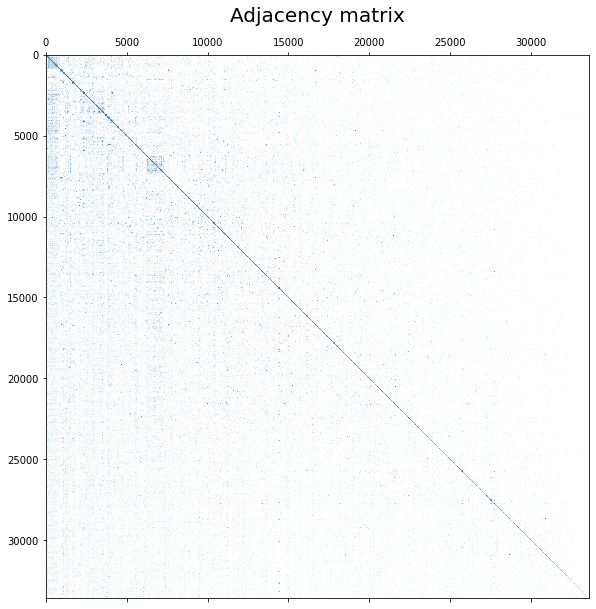

In [ ]:
A = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr')

fig = plt.figure(figsize=(13,10))
ax = plt.subplot()
ax.spy(A, aspect='equal',marker='.', markersize=0.06, alpha=0.2)
ax.set_title('Adjacency matrix', size=20)

plt.show()

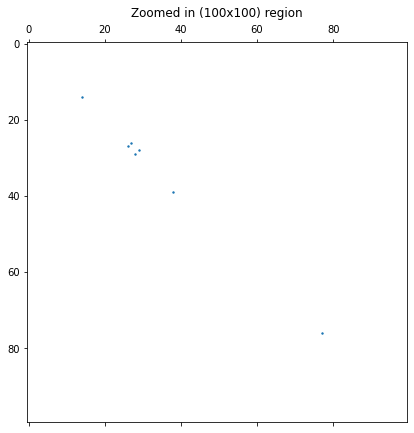

In [ ]:
# Zoomed in (100x100) region of A
fig = plt.figure(figsize=(10,7))
ax = plt.subplot()
ax.spy(A[33494:33594,33494:33594], aspect='equal',marker='.', markersize=2.8, alpha=1)
ax.set_title('Zoomed in (100x100) region', size=12)
plt.show()

In [ ]:
# Zoomed in (100x100) region of A
fig = plt.figure(figsize=(10,7))
ax = plt.subplot()
ax.spy(A[:100,:100], aspect='equal',marker='.', markersize=2.8, alpha=1)
ax.set_title('Zoomed in (100x100) region', size=12)
plt.show()

In [ ]:
def DiagonalSums(mat, n):
    """
    This function returns the sum of the diagonal element of a matrix.
    Inputs:
    - mat : matrix
    - n : matrix dimension
    Output:
    - diagonal_sum : sum of elements along the principal diagonal of the matrix mat
    """
    diagonal_sum = 0
    for i in range(0, n):
        for j in range(0, n):
            # Condition for principal diagonal
            if (i == j) and (A[i,j]!=0):
              diagonal_sum = diagonal_sum + 1
 
          
    return diagonal_sum

In [ ]:
# Check the number of self loops, i.e. the sum of diagonal elements that are equal to 1
print("Number of diagonal elements equal to 1:", DiagonalSums(A, 33593))

Number of diagonal elements equal to 1: 464


# Degree Distribution

### Network Degree

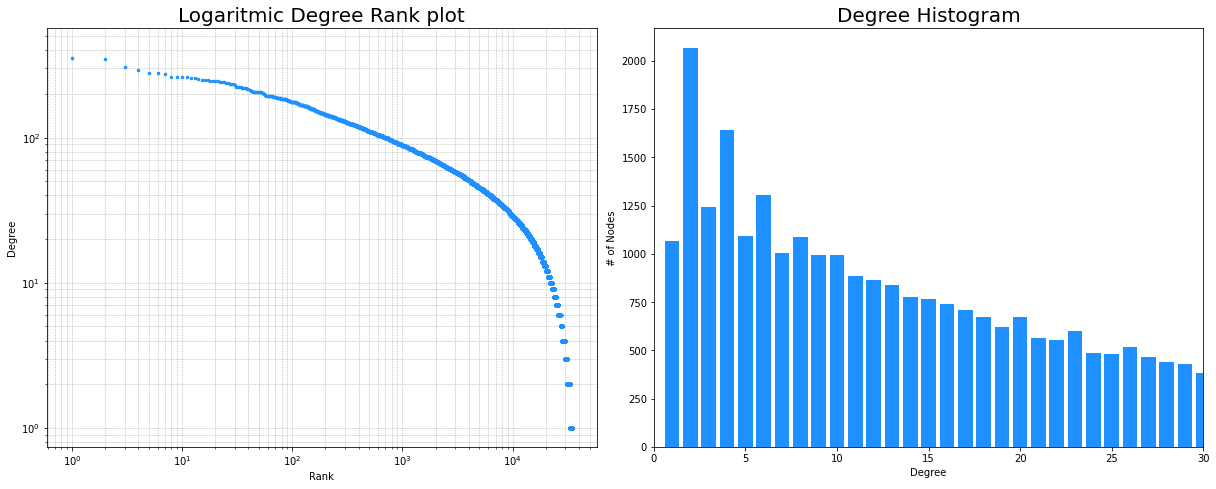

In [ ]:
# get the degrees sorted in descending order
degree_sequence = sorted([d for n, d in G.degree()], reverse=True) # G.degree() returns a DegreeView object capable of iterating (node_ID, degree) pairs

fig = plt.figure("Degree of a graph", figsize=(17, 16))
axgrid = fig.add_gridspec(5, 4) # Create a gridspec for adding subplots of different sizes

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.loglog(degree_sequence, "o", markersize=2.5, color="dodgerblue") # loglog tells matplotlib to use log scales
ax1.grid(which='both', linestyle='--', linewidth=0.5)
ax1.set_title("Logaritmic Degree Rank plot", size = 20)
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True), color="dodgerblue")
ax2.set_title("Degree Histogram", size = 20)
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")
ax2.set_xlim(0,30)

fig.tight_layout()

plt.show()

### IN degree & OUT degree

In [ ]:
def in_out_degree(G, in_degree=False, out_degree=False):
    """Return a list of the frequency of each degree value.

    Inputs:
    - G : Networkx graph
    - in_degree : bool
    - out_degree : bool

    Returns:
    - hist : list
       A list of frequencies of degrees.
       The degree values are the index in the list.
    """
    nodes = G.nodes() # node_IDs

    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]

    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
        
    else:
        degseq=[v for k, v in G.degree()]
   
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

In [ ]:
in_degree_freq = in_out_degree(G, in_degree=True)
out_degree_freq = in_out_degree(G, out_degree=True)
degree_freq = in_out_degree(G)

Text(0, 0.5, 'Frequency')

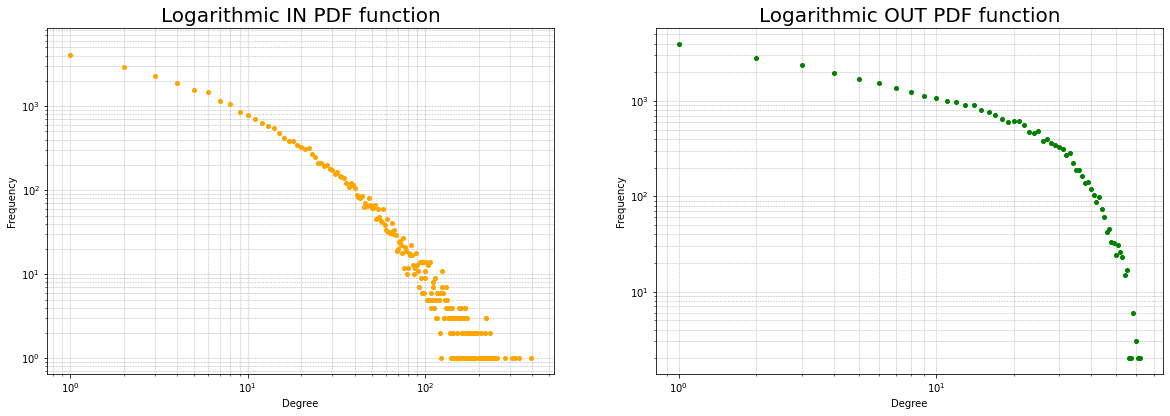

In [ ]:
plt.figure(figsize=(20, 14))
plt.subplot(2, 2, 1)
plt.loglog(range(len(in_degree_freq)), in_degree_freq, 'o', color='orange', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Logarithmic IN PDF function", size = 20)
plt.xlabel("Degree")
plt.ylabel("Frequency")

plt.subplot(2, 2, 2)
plt.loglog(range(len(out_degree_freq)), out_degree_freq, 'o', color='green', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Logarithmic OUT PDF function", size = 20)
plt.xlabel("Degree")
plt.ylabel("Frequency")

### IN & OUT Complementary Cumulative Distribution Function (CCDF)

Text(0, 0.5, 'Frequency')

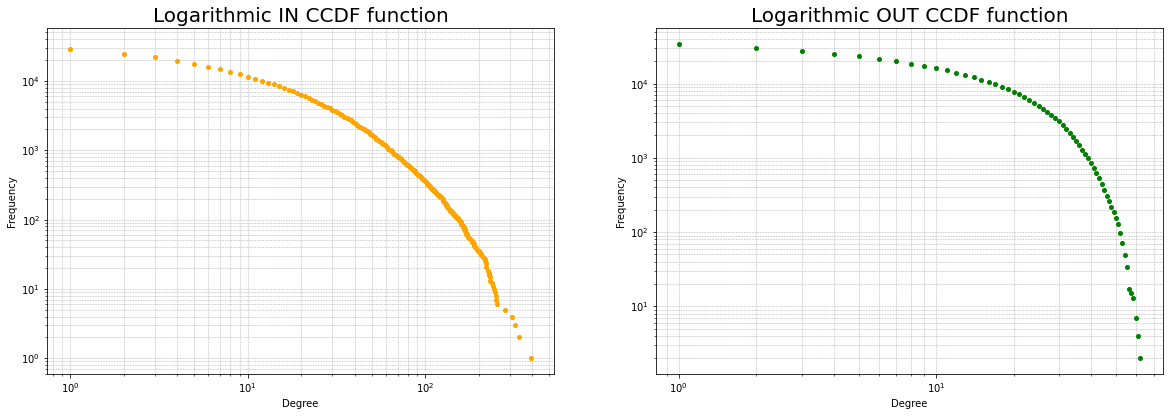

In [ ]:
# IN CCDF
in_degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)  
in_degreeCount = collections.Counter(in_degree_sequence) 
in_degree, in_count = zip(*in_degreeCount.items())
in_cs = np.cumsum(in_count)

plt.figure(figsize=(20, 14))
plt.subplot(2, 2, 1)
plt.loglog(in_degree, in_cs, 'o', color='orange', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Logarithmic IN CCDF function", size = 20)
plt.xlabel("Degree")
plt.ylabel("Frequency")

# OUT CCDF
out_degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)  
out_degreeCount = collections.Counter(out_degree_sequence) 
out_degree, out_count = zip(*out_degreeCount.items())
out_cs = np.cumsum(out_count)

plt.subplot(2, 2, 2)
plt.loglog(out_degree, out_cs, 'o', color='green', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Logarithmic OUT CCDF function", size = 20)
plt.xlabel("Degree")
plt.ylabel("Frequency")

### Estimating $\gamma$ (IN Distribution)

In [ ]:
sorted_d = sorted(in_degree)
occurrence = Counter(sorted_d)

x = list(Counter(occurrence).keys()) #values of the degrees
y = list(Counter(occurrence).values()) #counters for each degree

In [ ]:
kmin = [80,90, 105, 115, 130]
pk_res=[]
for k in kmin:
  in_degree = np.array(in_degree)
  d2 = in_degree[in_degree>k]
  ga = 1 + 1/mean(np.log(d2/k)) # ML estimate for gamma
  #gammas.append(ga)

  C = (ga-1)*k**(ga-1) # normalization condition
  # The fit is performed for values of k > kmin. So, only part of the data are considered and therefore the total 
  # probability is not 1 but is P_kmin
  pos = np.argmax(np.array(x)>=k)
  P_kmin = in_cs[pos] # constant value that shifts the line where the data are placed

  # degree distribution follows the power law
  x = [i for i in x if i != 0]
  pk = C*P_kmin*x**-ga 

  # CCDF 
  Pk_est = C*P_kmin*x**(-(ga-1))/(ga-1)
  
  pk_res.append([pk,Pk_est]) # each element correspond to a given kmin values ( each contain both pk and Pk_est)

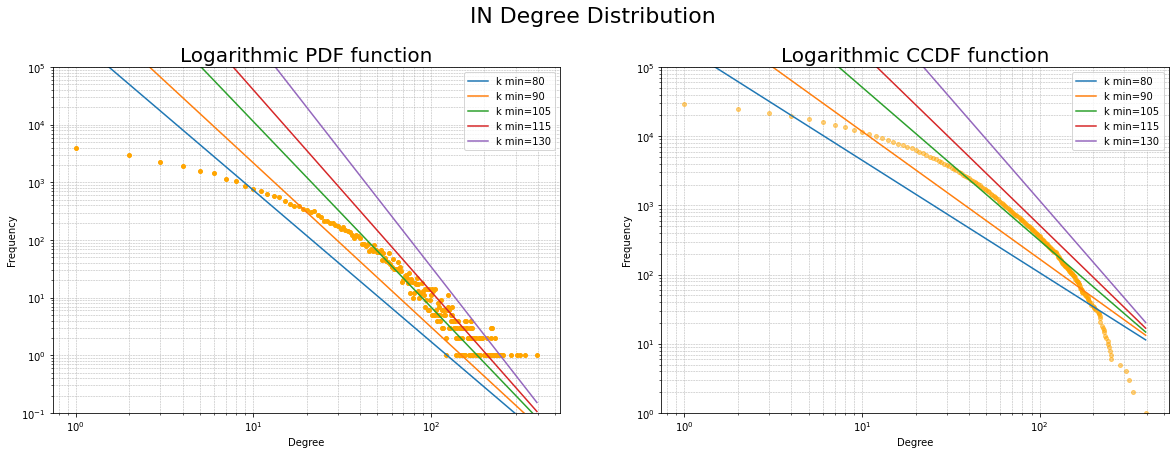

In [ ]:
plt.figure(figsize=(20, 14))
plt.subplot(2, 2, 1)
plt.suptitle("IN Degree Distribution",fontsize=22, y=0.94)
plt.loglog(range(len(in_degree_freq)), in_degree_freq, 'o', color='orange', markersize = 4)
for i,k in enumerate(kmin):
  plt.loglog(x, pk_res[i][0],label= "k min={}".format(k))
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Logarithmic PDF function", size = 20)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.ylim( (10**-1,10**5) )

plt.subplot(2, 2, 2)
plt.loglog(in_degree, in_cs, 'o', color='orange', alpha = 0.5, markersize = 4)
for i,k in enumerate(kmin):
  plt.loglog(x, pk_res[i][1], label= "k min={}".format(k))
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Logarithmic CCDF function", size = 20)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.ylim( (10**0,10**5) )

plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Discard samples in the saturation region, i.e. samples with degree < kmin
kmin = 105 #from the previous plot


# Fit gamma only in the chosen interval
in_degree = np.array(in_degree)
d2 = in_degree[in_degree>kmin]
ga = 1 + 1/mean(np.log(d2/kmin)) # ML estimate for gamma
print("Estimated \u03B3 =", -ga)

Estimated γ = -3.2164411139720395


In [ ]:
C = (ga-1)*kmin**(ga-1) # normalization condition

# The fit is performed for values of k > kmin. So, only part of the data are considered and therefore the total 
# probability is not 1 but is P_kmin
pos = np.argmax(np.array(x)>=kmin)
P_kmin = in_cs[pos] # constant value that shifts the line where the data are placed

# degree distribution follows the power law
x = [i for i in x if i != 0]
pk = C*P_kmin*x**-ga 

# CCDF 
Pk_est = C*P_kmin*x**(-(ga-1))/(ga-1)

print(C)

66911.88413418503


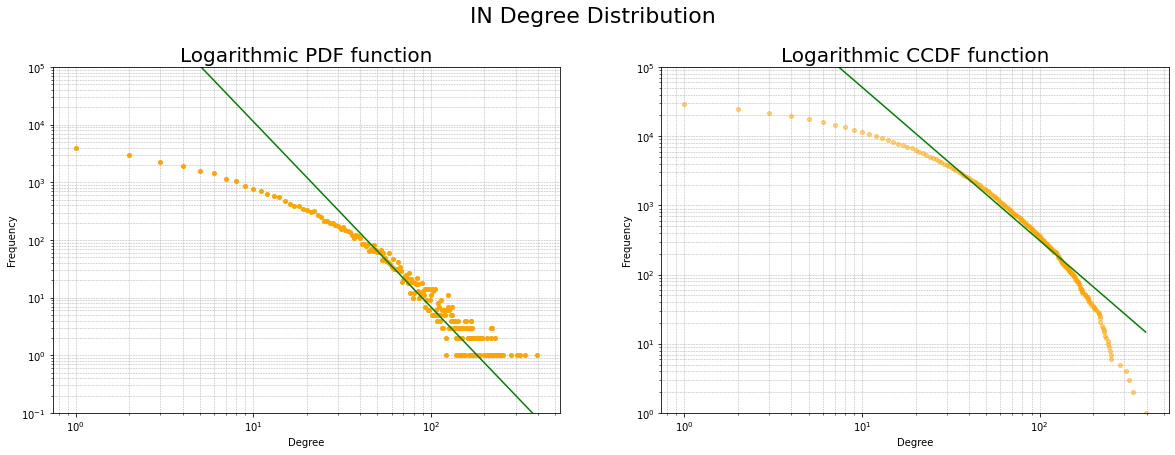

In [ ]:
plt.figure(figsize=(20, 14))
plt.suptitle("IN Degree Distribution",fontsize=22, y=0.94)
plt.subplot(2, 2, 1)
plt.loglog(range(len(in_degree_freq)), in_degree_freq, 'o', color='orange', markersize = 4)
plt.loglog(x, pk, color='green')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Logarithmic PDF function", size = 20)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.ylim( (10**-1,10**5) )

plt.subplot(2, 2, 2)
plt.loglog(in_degree, in_cs, 'o', color='orange', alpha = 0.5, markersize = 4)
plt.loglog(x, Pk_est, color='green')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Logarithmic CCDF function", size = 20)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.ylim( (10**0,10**5) )

plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Parameters

dmax = max(in_degree)
dmin = min(in_degree)
print("Max degree =", dmax)
print("Min degree =", dmin)
print("Average degree = ", np.mean(in_degree))
print("Second moment = ", moment(in_degree, moment = 2))
print("Third moment = ", moment(in_degree, moment = 3))

Max degree = 395
Min degree = 0
Average degree =  112.69626168224299
Second moment =  5425.82830378199
Third moment =  265852.36222401983


### Estimating $\gamma$ (OUT Distribution)

In [ ]:
kmin = [45, 52,55,60]
pk_res=[]
for k in kmin:
  out_degree = np.array(out_degree)
  d2 = out_degree[out_degree>k]
  ga = 1 + 1/mean(np.log(d2/k)) # ML estimate for gamma
  #gammas.append(ga)

  C = (ga-1)*k**(ga-1) # normalization condition
  # The fit is performed for values of k > kmin. So, only part of the data are considered and therefore the total 
  # probability is not 1 but is P_kmin
  pos = np.argmax(np.array(x)>=k)
  P_kmin = in_cs[pos] # constant value that shifts the line where the data are placed

  # degree distribution follows the power law
  x = [i for i in x if i != 0]
  pk = C*P_kmin*x**-ga 

  # CCDF 
  Pk_est = C*P_kmin*x**(-(ga-1))/(ga-1)
  
  pk_res.append([pk,Pk_est]) # each element correspond to a given kmin values ( each contain both pk and Pk_est)

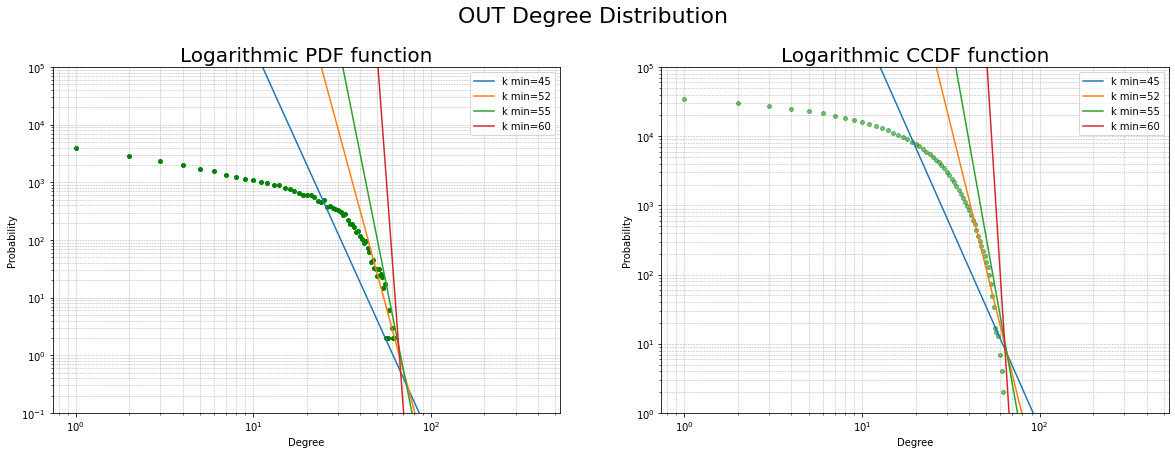

In [ ]:
plt.figure(figsize=(20, 14))
plt.subplot(2, 2, 1)
plt.suptitle("OUT Degree Distribution",fontsize=22, y=0.94)
plt.loglog(range(len(out_degree_freq)), out_degree_freq, 'o', color='green', markersize = 4)
for i,k in enumerate(kmin):
  plt.loglog(x, pk_res[i][0],label= "k min={}".format(k))
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Logarithmic PDF function", size = 20)
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.legend(loc="upper right")
plt.ylim( (10**-1,10**5) )

plt.subplot(2, 2, 2)
plt.loglog(out_degree, out_cs, 'o', color='green', alpha = 0.5, markersize = 4)
for i,k in enumerate(kmin):
  plt.loglog(x, pk_res[i][1], label= "k min={}".format(k))
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Logarithmic CCDF function", size = 20)
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.legend(loc="upper right")
plt.ylim( (10**0,10**5) )

plt.xlabel("Degree")
plt.ylabel("Probability")
plt.show()

In [ ]:
sorted_d = sorted(out_degree)
occurrence = Counter(sorted_d)

x = list(Counter(occurrence).keys()) #values of the degrees
y = list(Counter(occurrence).values()) #counters for each degree

# Discard samples in the saturation region, i.e. samples with degree < kmin
kmin = 52 # multiple values have been tried (with k = 60 the resulting fit is good)

# Fit gamma only in the chosen interval
out_degree = np.array(out_degree)
d2 = out_degree[out_degree>kmin]
ga = 1 + 1/mean(np.log(d2/kmin)) # ML estimate for gamma
print("Estimated \u03B3 =", -ga)

Estimated γ = -11.385240991461094


In [ ]:
C = (ga-1)*kmin**(ga-1) # normalization condition

# The fit is performed for values of k > kmin. So, only part of the data are considered and therefore the total 
# probability is not 1 but is P_kmin
pos = np.argmax(np.array(x)>=kmin)
P_kmin = in_cs[pos] # constant value that shifts the line where the data are placed

# degree distribution follows the power law
x = [i for i in x if i != 0]
pk = C*P_kmin*x**-ga 

# CCDF 
Pk_est = C*P_kmin*x**(-(ga-1))/(ga-1)

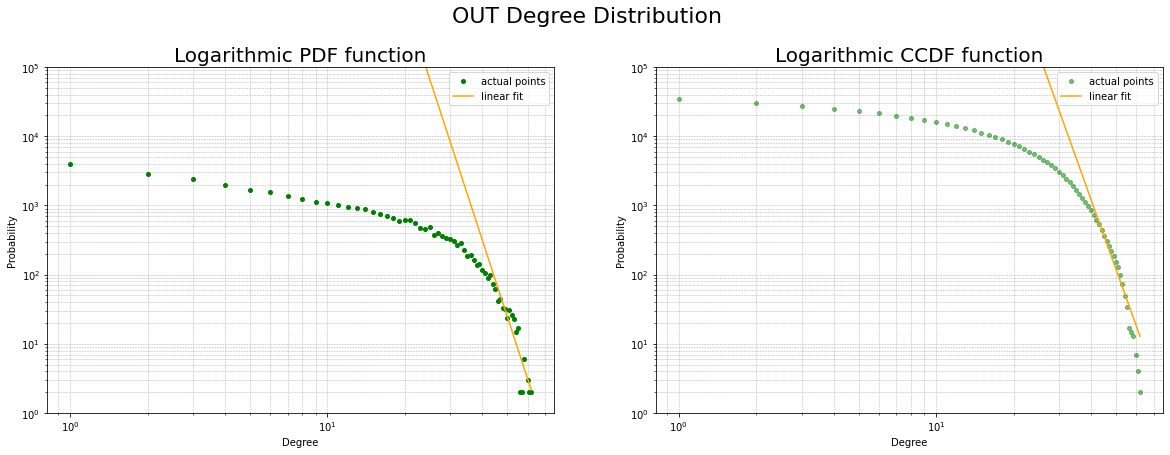

In [ ]:
plt.figure(figsize=(20, 14))
plt.suptitle("OUT Degree Distribution",fontsize=22, y=0.94)
plt.subplot(2, 2, 1)
plt.loglog(range(len(out_degree_freq)), out_degree_freq, 'o', color='green', markersize = 4, label = "actual points")
plt.loglog(x, pk, color='orange', label = "linear fit")
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Logarithmic PDF function", size = 20)
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.legend()
plt.ylim( (10**0,10**5) )

plt.subplot(2, 2, 2)
plt.loglog(out_degree, out_cs, 'o', color='green', alpha = 0.5, markersize = 4, label = "actual points")
plt.loglog(x, Pk_est, color='orange', label = "linear fit")
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Logarithmic CCDF function", size = 20)
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.legend()
plt.ylim( (10**0,10**5) )

plt.xlabel("Degree")
plt.ylabel("Probability")
plt.show()

In [ ]:
dmax = max(out_degree)
dmin = min(out_degree)
print("Max degree =", dmax)
print("Min degree =", dmin)
print("Average degree = ", np.mean(out_degree))
print("Second moment = ", moment(out_degree, moment = 2))
print("Third moment = ", moment(out_degree, moment = 3))

Max degree = 62
Min degree = 1
Average degree =  31.049180327868854
Second moment =  312.899220639613
Third moment =  82.34261898572869


# Assortativity

**Degree assortativity** of the graph, which is the tendency for nodes of high degree (resp. low degree) in a graph to be connected to high degree nodes (resp. to low degree ones), i.e. links are created between nodes with same degree. 



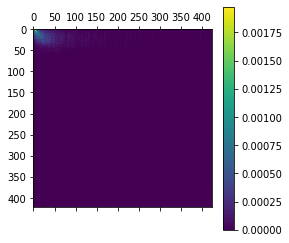

In [ ]:
#degree correlation matrix
mix_mat0 = nx.degree_mixing_matrix(G)
mix_mat0

##########
max_degree = max(deg for n, deg in G.degree)
mapping = {x: x for x in range(max_degree + 1)} # identity mapping
mix_mat = nx.degree_mixing_matrix(G, mapping=mapping)
mix_mat

plt.matshow(mix_mat);
plt.colorbar()
plt.show()

In [ ]:
def degree_assortativity(G, x, y):
  r = nx.degree_assortativity_coefficient(G, x, y)
  return r

In [ ]:
r_in_in = degree_assortativity(G, 'in', 'in')
print('r(in-in):',round(r_in_in,2))

r_in_out = degree_assortativity(G, 'in', 'out')
print('r(in-out):',round(r_in_out,2))

r_out_in = degree_assortativity(G, 'out', 'in')
print('r(out-in):',round(r_out_in,2))

r_out_out = degree_assortativity(G, 'out', 'out')
print('r(out-out):',round(r_out_out,2))

r(in-in): 0.13
r(in-out): 0.1
r(out-in): 0.21
r(out-out): 0.28


**Nearest neighbour degree** is the simplest form of assortativity: the correlation between the degree of a node and the average degree of its neighbors. 



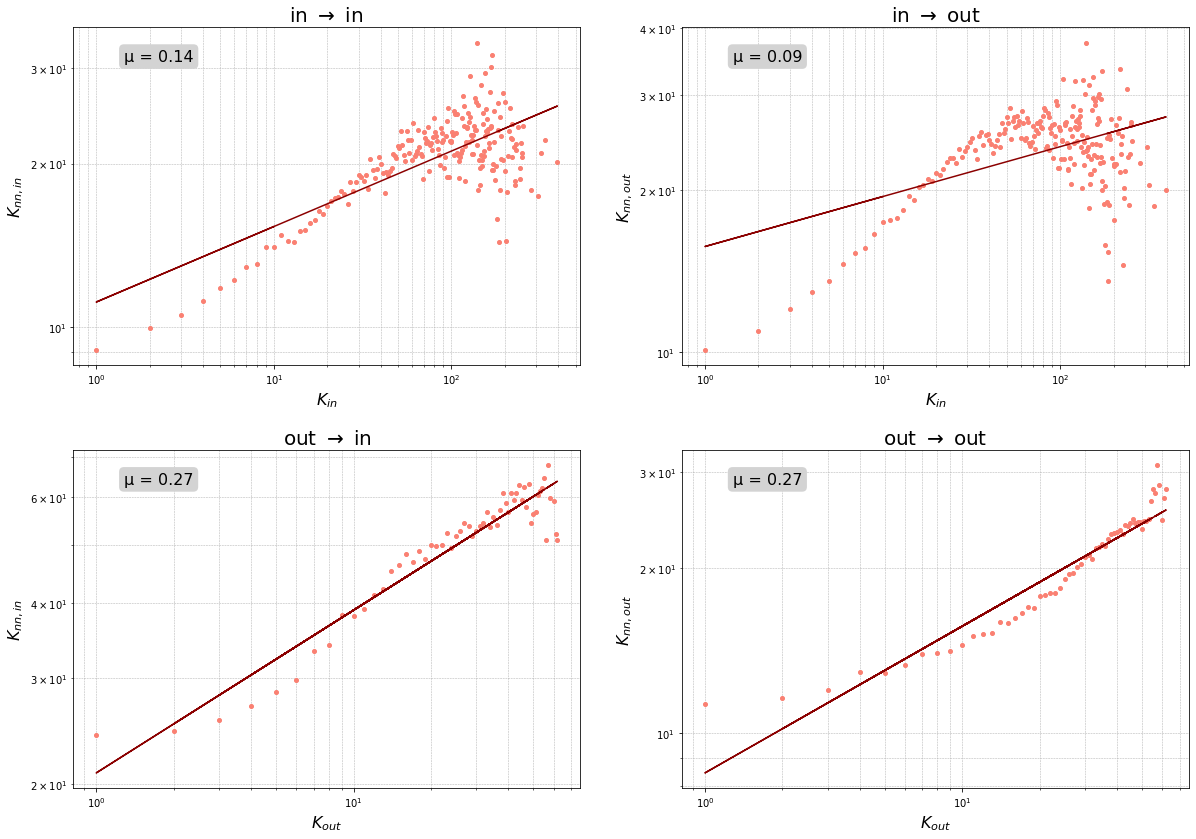

In [ ]:
# IN --> IN
# nx.average_degree_connectivity(G) returns a dictionary with unique node degrees as keys and matching average neighbors’ degrees as values
degree, average_neighbour_deg = zip(*nx.average_degree_connectivity(G, 'in', 'in').items()) # calculates the dictionary and separates the keys and values into two lists

plt.figure(figsize=(20, 14))
plt.subplot(2, 2, 1)
plt.loglog(degree, average_neighbour_deg, 'o', color='salmon', markersize = 4)

degree = [i for i in degree if i != 0] # removes degrees equal to zero 
average_neighbour_deg = [i for i in average_neighbour_deg if i != 0]
m_in_in, q = np.polyfit(np.log(degree),np.log(average_neighbour_deg),1) # slope and intercept of the fitting line
yfit = np.exp(m_in_in*np.log(degree)+q)
plt.loglog(degree, yfit, color='darkred')

plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("in $\\rightarrow$ in ", size = 20)
plt.annotate("\u03BC = "+str(round(m_in_in,2)), xy=(0.1,0.9), xycoords='axes fraction',
             fontsize=16, bbox=dict(boxstyle="round", fc="lightgrey", ec="none"))
plt.xlabel("$K_{in}$", size = 16)
plt.ylabel("$K_{nn,in}$", size = 16)


# IN --> OUT
degree, average_neighbour_deg = zip(*nx.average_degree_connectivity(G, 'in', 'out').items()) 

plt.subplot(2, 2, 2)
plt.loglog(degree, average_neighbour_deg, 'o', color='salmon', markersize = 4)

degree = [i for i in degree if i != 0] # removes degrees equal to zero 
average_neighbour_deg = [i for i in average_neighbour_deg if i != 0]
m_in_out, q = np.polyfit(np.log(degree),np.log(average_neighbour_deg),1) # slope and intercept of the fitting line
yfit = np.exp(m_in_out*np.log(degree)+q)
plt.loglog(degree, yfit, color='darkred')

plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("in $\\rightarrow$ out", size = 20)
plt.annotate("\u03BC = "+str(round(m_in_out,2)), xy=(0.1,0.9), xycoords='axes fraction',
             fontsize=16, bbox=dict(boxstyle="round", fc="lightgrey", ec="none"))
plt.xlabel("$K_{in}$", size = 16)
plt.ylabel("$K_{nn,out}$", size = 16)


# OUT --> IN
degree, average_neighbour_deg = zip(*nx.average_degree_connectivity(G, 'out', 'in').items()) 

plt.subplot(2, 2, 3)
plt.loglog(degree, average_neighbour_deg, 'o', color='salmon', markersize = 4)

degree = [i for i in degree if i != 0] # removes degrees equal to zero 
average_neighbour_deg = [i for i in average_neighbour_deg if i != 0]
m_out_in, q = np.polyfit(np.log(degree),np.log(average_neighbour_deg),1) # slope and intercept of the fitting line
yfit = np.exp(m_out_in*np.log(degree)+q)
plt.loglog(degree, yfit, color='darkred')

plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("out $\\rightarrow$ in", size = 20)
plt.annotate("\u03BC = "+str(round(m_out_in,2)), xy=(0.1,0.9), xycoords='axes fraction',
             fontsize=16, bbox=dict(boxstyle="round", fc="lightgrey", ec="none"))
plt.xlabel("$K_{out}$", size = 16)
plt.ylabel("$K_{nn,in}$", size = 16)

# OUT --> OUT
degree, average_neighbour_deg = zip(*nx.average_degree_connectivity(G, 'out', 'out').items()) 

plt.subplot(2, 2, 4)
plt.loglog(degree, average_neighbour_deg, 'o', color='salmon', markersize = 4)

degree = [i for i in degree if i != 0] # removes degrees equal to zero 
average_neighbour_deg = [i for i in average_neighbour_deg if i != 0]
m_out_out, q = np.polyfit(np.log(degree),np.log(average_neighbour_deg),1) # slope and intercept of the fitting line
yfit = np.exp(m_out_out*np.log(degree)+q)
plt.loglog(degree, yfit, color='darkred')

plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("out $\\rightarrow$ out", size = 20) #(\u03BC = "+str(round(m_out_out,2))+")"
plt.xlabel("$K_{out}$", size = 16)
plt.ylabel("$K_{nn,out}$", size = 16)
plt.annotate("\u03BC = "+str(round(m_out_out,2)), xy=(0.1,0.9), xycoords='axes fraction',
             fontsize=16, bbox=dict(boxstyle="round", fc="lightgrey", ec="none"))  


plt.subplots_adjust(hspace=0.25) #wspace, hspace
plt.show()

# Authorities and Hubs

In [ ]:
hubs, authorities = nx.hits(G, max_iter = 50, normalized = True)

### 10 biggest Hubs

In [ ]:
hubs = dict(sorted(hubs.items(), key=lambda item: item[1], reverse=True))
#list(hubs.items())[0:10]

id_['hubs'] = id_['ID'].map(hubs)
hubs = id_[['title','category','rank','hubs']].sort_values('hubs',ascending=False).reset_index(drop=True)
hubs.head(10)

,title,category,rank,hubs
0,Rawhide: Season 6 - Volume One,"[Movies & TV, Paramount Home Entertainment, Ac...",13714,0.003275
1,"Rawhide: Season 3, Vol. 1","[Movies & TV, Paramount Home Entertainment, Bo...",17947,0.003214
2,CHEYENNE SEASON 1 (FF)(DVD)(3PK),"[Movies & TV, Genre for Featured Categories, W...",5290,0.003173
3,"Rawhide: Season 4, Vol. 2","[Movies & TV, Paramount Home Entertainment, Bo...",25891,0.003169
4,30 Minutes to Fitness: Split Sessions Upper &a...,"[Movies & TV, Genre for Featured Categories, E...",56168,0.003164
5,"Vegas: Season 3, Vol. 2","[Movies & TV, Boxed Sets, Drama]",64560,0.003137
6,"Rawhide: Season 4, Vol. 1","[Movies & TV, Paramount Home Entertainment, Bo...",13122,0.003117
7,"Rawhide - Season Three, Vol. 2","[Movies & TV, Genre for Featured Categories, W...",35645,0.003091
8,Jakers! - Piggley Gets Into Trouble,"[Movies & TV, Paramount Home Entertainment, Co...",142237,0.003083
9,"Gunsmoke: Season 3, Vol. 2","[Movies & TV, Paramount Home Entertainment, Cl...",13932,0.003050


### 10 biggest Authorities

In [ ]:
authorities = dict(sorted(authorities.items(), key=lambda item: item[1], reverse=True))
list(authorities.items())[0:10]

id_['authorities'] = id_['ID'].map(authorities)
auth = id_[['title','category','rank','authorities']].sort_values('authorities',ascending=False).reset_index(drop=True)
auth.head(10)

,title,category,rank,authorities
0,CHEYENNE SEASON 1 (FF)(DVD)(3PK),"[Movies & TV, Genre for Featured Categories, W...",5290,0.008561
1,Cheyenne: Season 2,"[Movies & TV, Studio Specials, Warner Home Vid...",5460,0.008500
2,Tombstone Territory: The Complete TV Series,"[Movies & TV, Genre for Featured Categories, W...",44868,0.008351
3,"Gunsmoke: Season 11, Volume Two","[Movies & TV, Paramount Home Entertainment, Bo...",18975,0.008086
4,"Gunsmoke: Season 11, Volume One","[Movies & TV, Paramount Home Entertainment, Bo...",21833,0.008050
5,Bonanza: Season 3,"[Movies & TV, Paramount Home Entertainment, Dr...",17477,0.007853
6,Maverick: The Complete Season 2,"[Movies & TV, Genre for Featured Categories, W...",7768,0.007594
7,Cheyenne: Season 3,"[Movies & TV, Studio Specials, Warner Home Vid...",5196,0.007532
8,Death Valley Days: The Complete First Season,"[Movies & TV, Genre for Featured Categories, W...",49332,0.007409
9,Death Valley Days: The Complete Second Season,"[Movies & TV, Genre for Featured Categories, W...",17663,0.007401


### Which Authorities are also Hubs?

In [ ]:
equal = []
for i in range(100):
  for j in range(100):
    if auth.iloc[i,[0,1]].tolist() == hubs.iloc[j,[0,1]].tolist():
      equal.append(i)

In [ ]:
auth.iloc[equal,[0,-1]].reset_index(drop=True)

,title,authorities
0,CHEYENNE SEASON 1 (FF)(DVD)(3PK),0.008561
1,Cheyenne: Season 2,0.008500
2,Tombstone Territory: The Complete TV Series,0.008351
3,Bonanza: Season 3,0.007853
4,Maverick: The Complete Season 2,0.007594
5,Cheyenne: Season 3,0.007532
6,Death Valley Days: The Complete First Season,0.007409
7,Death Valley Days: The Complete Second Season,0.007401
8,Laramie: Season 2,0.006699
9,Cheyenne: The Complete Fourth Season,0.006635


### Rank Vs. Authorities / Hubs
Are the highest ranked items also Authorities or Hubs?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


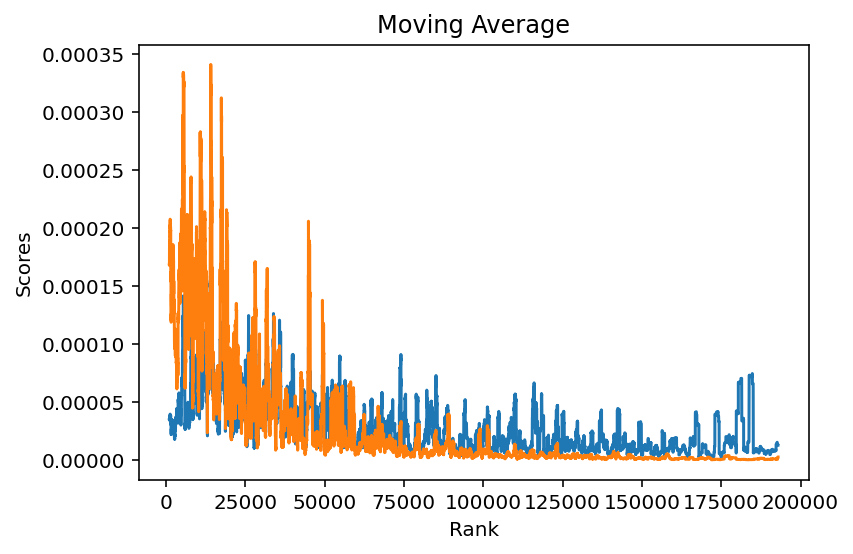

In [ ]:
%config InlineBackend.figure_format='retina'
from scipy import interpolate
from scipy.interpolate import splev, splrep,UnivariateSpline
prova = id_[['rank','hubs','authorities']]
prova['rank'] = pd.to_numeric(prova['rank'])
prova = prova.sort_values('rank',ascending=True,na_position='last')

n = 30000
x = prova['rank'][0:n]
y1 = prova['hubs'][0:n].rolling(window=100).mean()
y2 = prova['authorities'][0:n].rolling(window=100).mean()

plt.plot(x, y1)
plt.plot(x, y2)
plt.ylabel('Scores')
plt.xlabel('Rank')
plt.title('Moving Average')
plt.show()

#  Centrality measures and filtered network study





## Creating the filtered network 

In [ ]:
G = nx.from_pandas_edgelist(df,source='from_ID',target='to_ID', create_using=nx.DiGraph())
print(nx.info(G))

DiGraph with 33594 nodes and 401714 edges


In [ ]:
pagerank= nx.pagerank(G)

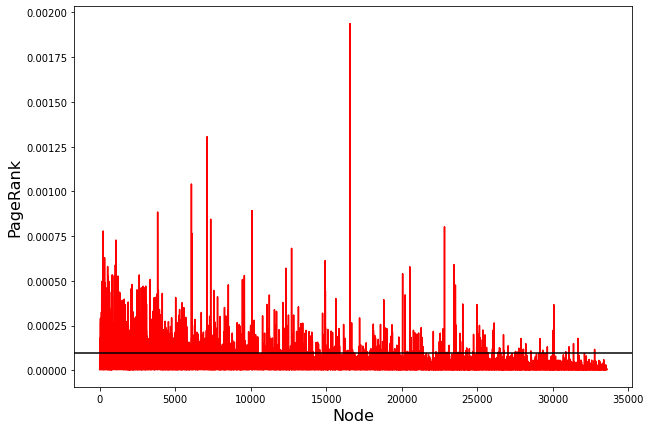

In [ ]:
plt.figure(figsize=(10, 7))

xx = range(0,len(pagerank.values()))
yy= list(pagerank.values())
plt.plot(xx,yy, color='r')
plt.xlabel("Node", size = 16)
plt.ylabel("PageRank", size = 16)
plt.axhline(y=9.43e-5, color='black', linestyle='-') 
plt.show()

#5% dei nodi di tutto il network - filtro pagerank 

In [ ]:
#Filtering 
threshold= 9.43e-5
id_mod = id_.copy()
id_mod["pagerank"] = id_mod.ID.map(nx.pagerank(G))
id_flt = id_mod[id_mod.pagerank > threshold]
id_flt = remove_alsobuy_not_present(id_flt, verbose=False)

In [ ]:
Gr= G.subgraph(id_flt.ID.values)
print("\nGraph original:", nx.info(Gr))


Graph original: DiGraph with 1664 nodes and 16677 edges


## Centrality measures

In [ ]:
degree = nx.degree_centrality(Gr)
pagerank= nx.pagerank(Gr, alpha=0.85)
closeness = nx.closeness_centrality(Gr)
betweenness = nx.betweenness_centrality(Gr)
eigenvector = nx.eigenvector_centrality(Gr, max_iter=600)
harmonic = nx.harmonic_centrality(Gr)


In [ ]:
pos = nx.spring_layout(Gr)

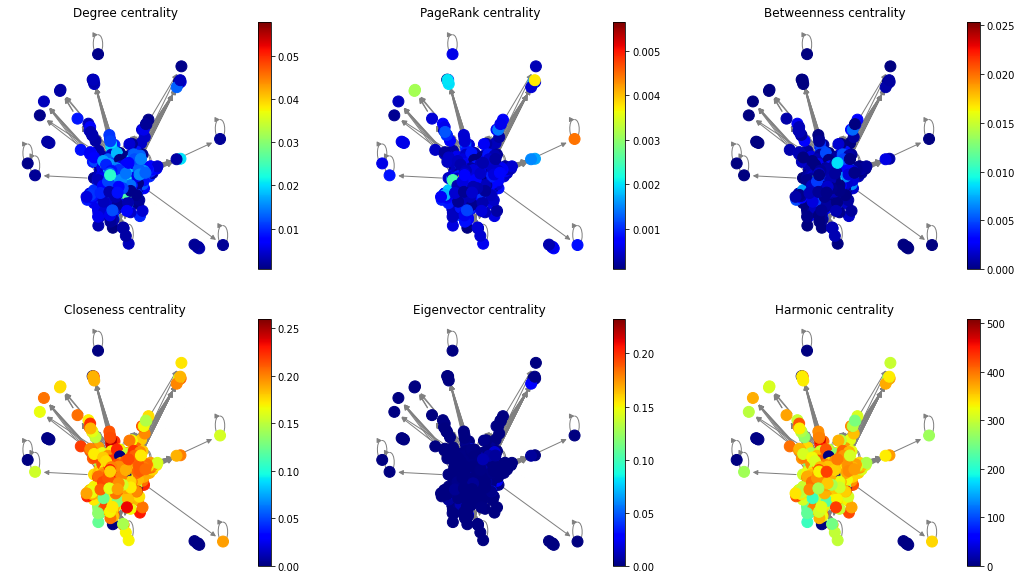

In [ ]:
import matplotlib.colors as colors

def draw(G, pos, measures, measure_name):
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=120, cmap=plt.cm.jet, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    edges = nx.draw_networkx_edges(G, pos, edge_color="grey")

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    
plt.figure(figsize=(18, 10)) 
plt.subplot(231)
draw(Gr, pos, degree, 'Degree centrality')

plt.subplot(232)
draw(Gr, pos, pagerank, 'PageRank centrality')

plt.subplot(233)
draw(Gr, pos, betweenness, 'Betweenness centrality')

plt.subplot(234)
draw(Gr, pos, closeness, 'Closeness centrality')

plt.subplot(235)
draw(Gr, pos, eigenvector, 'Eigenvector centrality')

plt.subplot(236)
draw(Gr, pos, harmonic, 'Harmonic centrality')

plt.show()

 # Robustness 

In [ ]:
Gr=nx.DiGraph.to_undirected(Gr)
ln_Gr = len(list(nx.nodes(Gr)))
between = nx.betweenness_centrality(Gr)
degree = nx.degree_centrality(Gr)
pagerk =nx.pagerank(Gr)


In [ ]:
def nth_moment(g,n):
    degree_np = np.array(list(dict(g.degree).values()))
    return (sum(degree_np**n)/len(g))
  
ratio = nth_moment(Gr,2)/nth_moment(Gr,1)
print("Ratio: {:.2f}".format(ratio))

fc=1-(1/(ratio-1))
print("Critical value: {:.2f}".format(fc))



Ratio: 21.35
Critical value: 0.95


In [ ]:
#Attacking the network 

sorted_x = sorted(between.items(), key=operator.itemgetter(1), reverse=True)
sorted_d = sorted(degree.items(), key=operator.itemgetter(1), reverse=True)
sorted_r = sorted(pagerk.items(), key=operator.itemgetter(1), reverse=True)


rand_x = list(range(ln_Gr))
random.shuffle(rand_x)

btwn = []
ranm = []
degr = []
pgrk = []
close =[]

G_c1=Gr.copy()
G_c2=Gr.copy()
G_c3=Gr.copy()
G_c4=Gr.copy()

for x in range(ln_Gr-1): 
 
        remove = sorted_x[x]     
        remove2 = sorted_x[rand_x[x]] 
        remove3 = sorted_d[x] 
        remove4 = sorted_r[x]
        remove5 = sorted_c[x]
        G_c1.remove_nodes_from(remove)
        G_c2.remove_nodes_from(remove2)
        G_c3.remove_nodes_from(remove3)
        G_c4.remove_nodes_from(remove4)

        #gsimple - betweeness
        connected_components1 = (G_c1.subgraph(c) for c in nx.connected_components(G_c1))
        max1 = max(connected_components1, key=len)
        #gsimple2 -random
        connected_components2 = (G_c2.subgraph(c) for c in nx.connected_components(G_c2))
        max2 = max(connected_components2, key=len)
        #gsimple3 -degree
        connected_components3 = (G_c3.subgraph(c) for c in nx.connected_components(G_c3))
        max3 = max(connected_components3, key=len)
        #gsimple4 -pagerank
        connected_components4 = (G_c4.subgraph(c) for c in nx.connected_components(G_c4))
        max4 = max(connected_components4, key=len)
        
        btwn_sg = len(max1)
        random_sg = len(max2)
        degr_sg = len(max3)
        pgrk_sg = len(max4)
        
        btwn.append(btwn_sg)
        ranm.append(random_sg)
        degr.append(degr_sg)
        pgrk.append(pgrk_sg)

In [ ]:
#The estimated fc corresponds to the point where the giant component first drops below 1% of its original size. 


break_btwn5 = round((np.argmax(np.array(btwn) < 0.05 * len(btwn)) / len(btwn))*100,0)
break_ranm5 = round((np.argmax(np.array(ranm) < 0.05 * len(ranm)) / len(ranm))*100,0)
break_degr5 = round((np.argmax(np.array(degr) < 0.05 * len(degr)) / len(degr))*100,0)
break_pgrk5 = round((np.argmax(np.array(pgrk) < 0.05 * len(pgrk)) / len(pgrk))*100,0)

break_btwn = round((np.argmax(np.array(btwn) < 0.01 * len(btwn)) / len(btwn))*100,0)
break_ranm = round((np.argmax(np.array(ranm) < 0.01 * len(ranm)) / len(ranm))*100,0)
break_degr = round((np.argmax(np.array(degr) < 0.01 * len(degr)) / len(degr))*100,0)
break_pgrk = round((np.argmax(np.array(pgrk) < 0.01 * len(pgrk)) / len(pgrk))*100,0)

In [ ]:
print("Values with 5% original size \n Breakdown betweeneess:", break_btwn5, "\n Breakdown random:", break_ranm5,
      "\n Breakdown degree", break_degr5, "\n Breakdown PageRank:", break_pgrk5)
print("Values with 1% original size  \n Breakdown betweeneess:", break_btwn ,"\n Breakdown random:", break_ranm,
      "\n Breakdown degree:", break_degr, "\n Breakdown PageRank:", break_pgrk)

Values with 5% original size 
 Breakdown betweeneess: 61.0 
 Breakdown random: 87.0 
 Breakdown degree 79.0 
 Breakdown PageRank: 67.0
Values with 1% original size  
 Breakdown betweeneess: 83.0 
 Breakdown random: 92.0 
 Breakdown degree: 86.0 
 Breakdown PageRank: 76.0


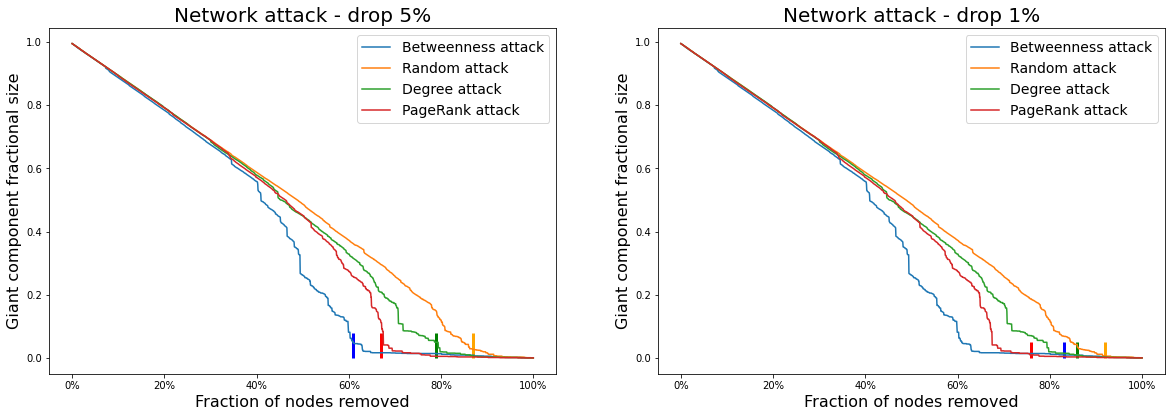

In [ ]:
#Plot 
perc = np.linspace(0,100,len(btwn))
plt.figure(figsize=(20, 14))

plt.subplot(221)
plt.plot(perc,np.array(btwn)/(ln_Gr-1)) 
plt.plot(perc,np.array(ranm)/(ln_Gr-1))
plt.plot(perc,np.array(degr)/(ln_Gr-1))
plt.plot(perc,np.array(pgrk)/(ln_Gr-1))
plt.vlines(break_btwn5, 0, 0.08, colors="blue",  linewidth=3)
plt.vlines(break_ranm5, 0, 0.08,  colors="orange", linewidth=3)
plt.vlines(break_degr5, 0, 0.08,  colors="green", linewidth=3)
plt.vlines(break_pgrk5, 0, 0.08,  colors="r" , linewidth=3)
plt.title("Network attack - drop 5%",size =20)


#legend
import matplotlib.ticker as mtick
fmt = '%.0f%%' 
xticks = mtick.FormatStrFormatter(fmt)
plt.gca().xaxis.set_major_formatter(xticks)
plt.xlabel('Fraction of nodes removed', size=16)
plt.ylabel('Giant component fractional size',size=16)
plt.legend(['Betweenness attack','Random attack', 'Degree attack', 'PageRank attack'], prop={'size': 14},facecolor="white")


plt.subplot(222)
plt.plot(perc,np.array(btwn)/(ln_Gr-1)) 
plt.plot(perc,np.array(ranm)/(ln_Gr-1))
plt.plot(perc,np.array(degr)/(ln_Gr-1))
plt.plot(perc,np.array(pgrk)/(ln_Gr-1))
plt.vlines(break_btwn, 0, 0.05, colors="blue",  linewidth=3)
plt.vlines(break_ranm, 0, 0.05,  colors="orange", linewidth=3)
plt.vlines(break_degr, 0, 0.05,  colors="green", linewidth=3)
plt.vlines(break_pgrk, 0, 0.05,  colors="r" , linewidth=3)
plt.title("Network attack - drop 1%",size =20)


#legend
import matplotlib.ticker as mtick
fmt = '%.0f%%' 
xticks = mtick.FormatStrFormatter(fmt)
plt.gca().xaxis.set_major_formatter(xticks)
plt.xlabel('Fraction of nodes removed', size=16)
plt.ylabel('Giant component fractional size',size=16)
plt.legend(['Betweenness attack','Random attack', 'Degree attack', 'PageRank attack'], prop={'size': 14})


# Community Detection

Community Detection per gift cards, si vede che ci sono delle community per i brand questo non è male (bisogna interpretare i risultati).

N.B. La community detection vale solo per UN-directed Graphs (quindi il grafico sotto non ha frecce)

## Supernodes for the category


**Add main category and pagerank to dataframe**

In [ ]:
import networkx.algorithms.community as nxcom
import matplotlib.pyplot as plt
import community as community_louvain
import matplotlib.cm as cm

In [ ]:
all_dict_first_cat = []
for i in range(len(id_)):
  all_dict_first_cat.append((id_.iloc[i,0],id_.iloc[i,7][1] ))

all_dict_first_cat= dict(all_dict_first_cat)
print(all_dict_first_cat)

{'0000143588': 'Movies', '0012175447': 'Genre for Featured Categories', '0307142493': 'Science Fiction & Fantasy', '0510539610': 'Movies', '0679884815': 'Genre for Featured Categories', '0738920762': 'Studio Specials', '0738920061': 'Science Fiction & Fantasy', '0739073095': 'Musicals & Performing Arts', '0740316591': 'Genre for Featured Categories', '0740318764': 'Genre for Featured Categories', '0767020294': 'A&E Home Video', '0767018699': 'A&E Home Video', '0767023447': 'Musicals & Performing Arts', '0767804325': 'Studio Specials', '0767811089': 'Studio Specials', '0767805712': 'Science Fiction & Fantasy', '0767817486': 'Studio Specials', '0767809726': 'Studio Specials', '0767817648': 'Studio Specials', '0767818105': 'Studio Specials', '0767817664': 'Studio Specials', '0767824555': 'Studio Specials', '0767821807': 'Studio Specials', '0767827686': 'Studio Specials', '0767817737': 'Studio Specials', '0767824571': 'Studio Specials', '0767830555': 'Studio Specials', '0767803434': 'Studi

In [ ]:
id_mod = id_.copy()

#add column "community_new" with the main category of each node
id_mod["main_category"] = id_mod.ID.map(all_dict_first_cat)
id_mod

,ID,title,also_buy,also_view,price,rank,brand,category,main_category
0,0000143588,"Barefoot Contessa (with Ina Garten), Entertain...","[B00N27ID1G, B000NR7ROM, B000AOEPMA, B000UMP2V...","[B002I5GNW4, 0804187045, B009UY3W8O, 060960219...",74.95,342914,Ina Garten,"[Movies & TV, Movies]",Movies
1,0012175447,DVD-Cedarmont Kids: Gospel Bible Songs,[B00006L93S],"[B00005CBYX, B0010X5UGU, B000BR9LY8, B0010WAC5...",18.47,92167,Cedarmont Kids,"[Movies & TV, Genre for Featured Categories, K...",Genre for Featured Categories
2,0307142493,Santa Claus Is Comin' To Town VHS,"[6301752694, 6300274268]","[B0057FGCJQ, 0307142469, B00005M2FD, B00LEW3JN...",1.99,347709,Fred Astaire,"[Movies & TV, Science Fiction & Fantasy, Scien...",Science Fiction & Fantasy
3,0510539610,Hab It: Pelvic Floor,"[B00HHITD60, B00E8A0OZ4]","[0553380842, 1936303213, B00006D2R8, 099308770...",29.95,15934,Tasha Mulligan,"[Movies & TV, Movies]",Movies
4,0679884815,Arthur - Arthur Writes a Story VHS,"[6305384452, B00005T7H7, B00005RYPJ, B00004TJK4]","[0679884777, 0679884858, B00004RERR, 067988487...",18.85,188360,J.T. Turner,"[Movies & TV, Genre for Featured Categories, A...",Genre for Featured Categories
...,...,...,...,...,...,...,...,...,...
33589,B01HID7MM0,Forces of Nature,"[B00IWULSTC, B005SH65UO, B00B5ACNQI, B002EZLO0...","[B01LYQFYV6, B001W79MQS, B004XKVQVU, B07J33SHK...",29.99,205569,Professor Brian Cox,"[Movies & TV, Blu-ray, Movies]",Blu-ray
33590,B01HIQ3TO2,Barbie: Star Light Adventure,"[B019GY79LS, B013HY6KVS, B00QRPZEVW, B00HDAG7F...","[B01ARGBMXK, B019GY79LS, B07FDQRK8T, B00L8QP0C...",16.95,85690,Erica Lindbeck,"[Movies & TV, Blu-ray, Movies]",Blu-ray
33591,B01HIUL6WU,All the Way (Digital HD/DVD),"[B004YDSNMQ, B007KAUWO2, B00NMF8SEK, B00008W2O...","[B077SKJCWZ, B001BSBC16, B00CLH08KC, B078952HS...",7.90,50367,Various,"[Movies & TV, HBO, All HBO Titles]",HBO
33592,B01HJ1INB0,Verdi: Otello,"[B014HFML6E, B000F3T3CS, B000094HMU, B004QQDUZ...","[B07BF2PQHM, B00012AST0, B0094AH3Q6, B0007P0LP...",14.98,68026,Sonya Yoncheva,"[Movies & TV, Studio Specials, Sony Pictures H...",Studio Specials


In [ ]:
# saving nodelist of all the dataset
id_mod.to_csv('nodes_all.csv', index=False)

In [ ]:
print("The number of main categories of the network are: ", len(np.unique(id_mod.main_category.values))  )

The number of main categories of the network are:  66


In [ ]:
### Creating edgelist for network with supernodes corresponding to category
df_test = id_mod[["ID","also_buy","main_category"]].explode("also_buy", ignore_index=True)
df_test.columns = ['from_ID','to_ID',"main_category"] 

# saving edgelist of all the dataset
df_test.to_csv('edgelist_all.csv', index=False)

In [ ]:
G = nx.from_pandas_edgelist( df_test, source='from_ID',target='to_ID', create_using=nx.DiGraph())
print(nx.info(G))

DiGraph with 33594 nodes and 401714 edges


In [ ]:
#create a column with associated pagerank
id_mod["pagerank"] = id_mod.ID.map(nx.pagerank(G))
#id_mod

In [ ]:
# Create SUPERNODES column with high pagerank for each category

id_mod["SNodes"] = np.zeros(len(id_mod))

sn={}
for i,cat in enumerate(np.unique(id_mod.main_category)):
    tmp = id_mod[id_mod.main_category== cat]
    max_pg= tmp[tmp.pagerank == max(tmp.pagerank)].ID.values[0]
    sn[max_pg]=1

id_mod["SNodes"]=id_mod.ID.map(sn)
id_mod.fillna(0,inplace=True)

In [ ]:
#id_mod = remove_alsobuy_not_present(id_mod, verbose=False)
id_mod

,ID,title,also_buy,also_view,price,rank,brand,category,main_category,pagerank,SNodes
0,0000143588,"Barefoot Contessa (with Ina Garten), Entertain...","[B00N27ID1G, B000NR7ROM, B000AOEPMA, B000UMP2V...","[B002I5GNW4, 0804187045, B009UY3W8O, 060960219...",74.95,342914,Ina Garten,"[Movies & TV, Movies]",Movies,0.000004,0.0
1,0012175447,DVD-Cedarmont Kids: Gospel Bible Songs,[B00006L93S],"[B00005CBYX, B0010X5UGU, B000BR9LY8, B0010WAC5...",18.47,92167,Cedarmont Kids,"[Movies & TV, Genre for Featured Categories, K...",Genre for Featured Categories,0.000007,0.0
2,0307142493,Santa Claus Is Comin' To Town VHS,"[6301752694, 6300274268]","[B0057FGCJQ, 0307142469, B00005M2FD, B00LEW3JN...",1.99,347709,Fred Astaire,"[Movies & TV, Science Fiction & Fantasy, Scien...",Science Fiction & Fantasy,0.000004,0.0
3,0510539610,Hab It: Pelvic Floor,"[B00HHITD60, B00E8A0OZ4]","[0553380842, 1936303213, B00006D2R8, 099308770...",29.95,15934,Tasha Mulligan,"[Movies & TV, Movies]",Movies,0.000032,0.0
4,0679884815,Arthur - Arthur Writes a Story VHS,"[6305384452, B00005T7H7, B00005RYPJ, B00004TJK4]","[0679884777, 0679884858, B00004RERR, 067988487...",18.85,188360,J.T. Turner,"[Movies & TV, Genre for Featured Categories, A...",Genre for Featured Categories,0.000013,0.0
...,...,...,...,...,...,...,...,...,...,...,...
33589,B01HID7MM0,Forces of Nature,"[B00IWULSTC, B005SH65UO, B00B5ACNQI, B002EZLO0...","[B01LYQFYV6, B001W79MQS, B004XKVQVU, B07J33SHK...",29.99,205569,Professor Brian Cox,"[Movies & TV, Blu-ray, Movies]",Blu-ray,0.000004,0.0
33590,B01HIQ3TO2,Barbie: Star Light Adventure,"[B019GY79LS, B013HY6KVS, B00QRPZEVW, B00HDAG7F...","[B01ARGBMXK, B019GY79LS, B07FDQRK8T, B00L8QP0C...",16.95,85690,Erica Lindbeck,"[Movies & TV, Blu-ray, Movies]",Blu-ray,0.000037,0.0
33591,B01HIUL6WU,All the Way (Digital HD/DVD),"[B004YDSNMQ, B007KAUWO2, B00NMF8SEK, B00008W2O...","[B077SKJCWZ, B001BSBC16, B00CLH08KC, B078952HS...",7.90,50367,Various,"[Movies & TV, HBO, All HBO Titles]",HBO,0.000055,0.0
33592,B01HJ1INB0,Verdi: Otello,"[B014HFML6E, B000F3T3CS, B000094HMU, B004QQDUZ...","[B07BF2PQHM, B00012AST0, B0094AH3Q6, B0007P0LP...",14.98,68026,Sonya Yoncheva,"[Movies & TV, Studio Specials, Sony Pictures H...",Studio Specials,0.000037,0.0


## Community detection with greedy modularity communities


 This methods simply assign the community number to the nodes and edges

In [ ]:
G = nx.from_pandas_edgelist( df_test, source='from_ID',target='to_ID', create_using=nx.DiGraph())
print(nx.info(G))

DiGraph with 33594 nodes and 401714 edges


### Filtering based on PAGERANK value

In [ ]:
threshold= 9.43e-5
id_flt = id_mod[id_mod.pagerank > threshold]
id_flt = remove_alsobuy_not_present(id_flt,verbose=True)
id_flt

Computing... (1-times)  (#rows = 1750)

Computing... (2-times)  (#rows = 1677)

Computing... (3-times)  (#rows = 1667)

Computing... (4-times)  (#rows = 1665)

Computing... (5-times)  (#rows = 1664)


DONE.


,ID,title,also_buy,also_view,price,rank,brand,category,main_category,pagerank,SNodes
0,0767817664,Fright Night,"[1573305588, B00OQRU968]","[B003Y5H5FG, B00P0F1072, B00C2CDJ34, B00009YXH...",7.99,9194,Amanda Bearse,"[Movies & TV, Studio Specials, Sony Pictures H...",Studio Specials,0.000203,0.0
1,0767803434,Air Force One,"[B003Y5H5FG, B001DJLD1W, B000Q66Q56, B00VAVNN5W]","[B0004Z33EG, B0004Z33F0, B000YCPUWW, B01N07R0X...",6.88,14175,Wendy Crewson,"[Movies & TV, Studio Specials, Sony Pictures H...",Studio Specials,0.000106,0.0
2,0783114907,Sweet Dreams,"[B00AFEYJ80, B00DDT0JB0, B00B83ROIE]","[B008R65XOM, B0009OUBGK, B000A50460, B00AFEYJ8...",5.98,2893,Ed Harris,"[Movies & TV, HBO, All HBO Titles]",HBO,0.000198,0.0
3,0783116926,The Changeling,"[B00ZGIOL42, B00LVZK1FW, B000U1ZV7G, B001EAWMG...","[B001NFNFNU, B01LTHXLZ8, B0045HCJJE, B00023P4T...",5.98,5390,George C. Scott,"[Movies & TV, Genre for Featured Categories, A...",Genre for Featured Categories,0.000218,0.0
4,0783226853,The Day of the Jackal,"[B000PFUAPK, B000KJU13C]","[B00441GYYC, B004VQRCHS, B00104AYL0, B01GWCBLN...",9.96,19770,Edward Fox,"[Movies & TV, Genre for Featured Categories, A...",Genre for Featured Categories,0.000158,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1659,B01HEA2QEG,Daniel Tiger's Neighborhood: Daniel's Winter W...,"[B001O4KBNM, B00MNOLCLW, B001DSNEME]","[B06XN6RN6P, B07BFBT3LD, B00K6K9GKO, B01MQGVNU...",4.99,4398,n/a,"[Movies & TV, Holidays & Seasonal, Christmas]",Holidays & Seasonal,0.000135,0.0
1660,B01HEXUFAK,The Melancholy of Haruhi Suzumiya: Seasons One...,"[B00KU3Y5CG, B008YRL7JE, B0102AL8V2, B00II6C66...","[B06X9C1HHR, B01EIW2RMO, B00KU3Y5CG, B01HEY3SI...",40.09,18977,Wendee Lee,"[Movies & TV, Science Fiction & Fantasy, Scien...",Science Fiction & Fantasy,0.000198,0.0
1661,B01HEXVJJG,Psycho-Pass: Season One,"[B01EIW2RMO, B00KU3Y5CG, B004DMIIPA, B00V7ORQI...","[B07D4ZPJCP, B01D7A93CU, B07FQ321FZ, B01995ZGQ...",34.67,14379,Robert McCollum,"[Movies & TV, Boxed Sets, Anime]",Boxed Sets,0.000351,0.0
1662,B01HH20HH4,Thomas &amp; Friends: The Great Race - The Movie,"[B00ZR3W3WI, B00LAYEN4Y, B00E21QTG2, B00MN9PQ2...","[B00ZR3W3WI, B00DP3E2HG, B01LAQPG6A, B00LAYEN4...",9.99,2985,Tina Desai,"[Movies & TV, Genre for Featured Categories, K...",Genre for Featured Categories,0.000102,0.0


In [ ]:
print("Graph original:", nx.info(G))
G_flt= G.subgraph(id_flt.ID.values)
print("\nGraph original:", nx.info(G_flt))

#nx.write_edgelist(G, "test.edgelist.gz", delimiter=",", data=False)

Graph original: DiGraph with 33594 nodes and 401714 edges

Graph original: DiGraph with 1664 nodes and 16677 edges


In [ ]:
#print("If you want to use the filtered graph, insert '0',\n(otherwise original graph will be consider): \n\n")

#x= input("Select --> '0' <-- for original graph:\n(otherwise filtered graph will be consider)\t")
x = 1
G_or = nx.from_pandas_edgelist( df_test, source='from_ID',target='to_ID', create_using=nx.DiGraph())

if x != '0':
  G=G_flt.copy()
  print("\n\n--> Filtered version selected")
else:
  G=G_or.copy()
  print("\\n\n--> Original versione selected")



--> Filtered version selected


In [ ]:
import time
st_time= time.time()
### Find the communities
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)

fin_time= time.time()

 ### Count the communities
print(f"The Graph with 'greedy_modularity_optimization' has {len(communities)} communities.")

print("Time needed for the computation:", round(fin_time-st_time,3), "s")


id_flt_mod = id_flt.copy()

#add column "community"
dict_communities = { k:v for v,com in enumerate(communities) for k in com } 
id_flt_mod["community"] = id_flt_mod.ID.map(dict_communities)

The Graph with 'greedy_modularity_optimization' has 18 communities.
Time needed for the computation: 5.858 s


In [ ]:
id_flt_1 = id_flt_mod.copy()
id_flt_1 = remove_alsobuy_not_present(id_flt_1, verbose=False)

In [ ]:
#saving the nodelist for gephi
if len(id_flt_1)< len(G_or):
  id_flt_1.to_csv("nodes_GMC_filtered.csv", index=False)
  print(" File 'nodes_GMC_filtered.csv' has been created")
else:
  id_flt_1.to_csv("nodes_GMC_all.csv", index=False)
  print(" File 'nodes_GMC_all.csv' has been created")


# Saving edgelist for gephi
df_flt = id_flt_1[["ID","also_buy","community"]].explode("also_buy", ignore_index=True)
df_flt.columns = ['from_ID','to_ID',"community"]

if len(id_flt_1)< len(G_or):
  df_flt.to_csv("edgelist_GMC_filtered.csv", index=False)
  print(" File 'edgelist_GMC_filtered.csv' has been created")
else:
  df_flt.to_csv("edgelist_GMC_all.csv", index=False)
  print(" File 'edgelist_GMC_all.csv' has been created")


 File 'nodes_GMC_filtered.csv' has been created
 File 'edgelist_GMC_filtered.csv' has been created


## GIRVAN-NEWMAN community detection

The Girvan–Newman algorithm detects communities by progressively removing edges from the original network. The connected components of the remaining network are the communities. Instead of trying to construct a measure that tells us which edges are the most central to communities, the Girvan–Newman algorithm focuses on edges that are most likely “between” communities.

In [ ]:
print(nx.info(G))

st_time= time.time()

result = nxcom.girvan_newman(G)
communities = next(result)

 ### Count the communities
print(f"The Graph has {len(communities)} communities.")

fin_time= time.time()
print("Time needed for the computation:", round(fin_time-st_time,3), "sec")

DiGraph with 1664 nodes and 16677 edges
The Graph has 6 communities.
Time needed for the computation: 1637.251 sec


In [ ]:
id_flt_mod = id_flt.copy()

#add column "community"
dict_communities = { k:v for v,com in enumerate(communities) for k in com } 
id_flt_mod["community"] = id_flt_mod.ID.map(dict_communities)
#id_flt_mod

In [ ]:
id_flt_mod1 = id_flt_mod.copy()
id_flt_mod1 = remove_alsobuy_not_present(id_flt_mod1, verbose=False)


In [ ]:
#saving the nodelist
if len(id_flt_mod1)< len(G_or):
  id_flt_mod1.to_csv("nodes_GIR_NEW_filtered.csv", index=False)
  print(" File 'nodes_GIR_NEW_filtered.csv' has been created")
else:
  id_flt_mod1.to_csv("nodes_GIR_NEW_all.csv", index=False)
  print(" File 'nodes_GIR_NEW_all.csv' has been created")

 File 'nodes_GIR_NEW_filtered.csv' has been created


In [ ]:
# Creating edgelist
df_flt = id_flt_mod1[["ID","also_buy","community"]].explode("also_buy", ignore_index=True)
df_flt.columns = ['from_ID','to_ID',"community"]

if len(id_flt_mod1)< len(G_or):
  df_flt.to_csv("edgelist_GIR_NEW_filtered.csv", index=False)
  print(" File 'edgelist_GIR_NEW_filtered.csv' has been created")
else:
  df_flt.to_csv("edgelist_GIR_NEW_all.csv", index=False)
  print(" File 'edgelist_GIR_NEW_all.csv' has been created")


 File 'edgelist_GIR_NEW_filtered.csv' has been created


# Link Prediction

Link prediction implementation and final checking if the **also_view** column has some common elements with our classifier suggestions

In [ ]:
G = nx.from_pandas_edgelist(df,source='from_ID',target='to_ID', create_using=nx.DiGraph())
G.remove_edges_from(nx.selfloop_edges(G))
print(nx.info(G))

DiGraph with 33594 nodes and 401250 edges


### Extracting network & nodes properties

Creating the node2Vec representation

In [ ]:
if not os.path.exists('temp_node2vec'):
    os.makedirs('temp_node2vec')
node2vec = Node2Vec(G, dimensions=32, walk_length=20, num_walks=10, workers=4, temp_folder='temp_node2vec') 

Computing transition probabilities:   0%|          | 0/33594 [00:00<?, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/3 [00:00<?, ?it/s]


Generating walks (CPU: 3):   0%|          | 0/2 [00:00<?, ?it/s]

Generating walks (CPU: 4):   0%|          | 0/2 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [07:10<00:00, 215.45s/it]


Generating walks (CPU: 2): 100%|██████████| 3/3 [17:00<00:00, 340.32s/it]


In [ ]:
# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  

Adding cosine similarity to the node vectors

In [ ]:
G = nx.from_pandas_edgelist(df,source='from_ID',target='to_ID', create_using=nx.Graph())
G.remove_edges_from(nx.selfloop_edges(G))
print(nx.info(G))

Graph with 33594 nodes and 347153 edges


Adding the others network properties

In [ ]:
df_link = df.iloc[:,:]
df_link['nodes']=list(zip(df_link.from_ID, df_link.to_ID))
df_link['connection'] = 1

jc=nx.jaccard_coefficient(G, ebunch=df_link['nodes'].tolist())
jc = pd.DataFrame(jc)
df_link['jc'] = jc[2]

#add resource allocation to network dataframe
ra = nx.resource_allocation_index(G, ebunch=df_link['nodes'].tolist())
ra = pd.DataFrame(ra)
df_link['resource_a'] = ra[2]

#add preferential attachment to network dataframe
pa = nx.preferential_attachment(G, ebunch=df_link['nodes'].tolist())
pa = pd.DataFrame(pa)
df_link['pref_a'] = pa[2]

#df_link['weight'] = sim_score

df_link.head(5)

,from_ID,to_ID,nodes,connection,jc,resource_a,pref_a
0,0000143588,B00N27ID1G,"(0000143588, B00N27ID1G)",1,0.160000,0.546703,154
1,0000143588,B000NR7ROM,"(0000143588, B000NR7ROM)",1,0.166667,0.071770,49
2,0000143588,B000AOEPMA,"(0000143588, B000AOEPMA)",1,0.111111,0.071770,91
3,0000143588,B000UMP2VK,"(0000143588, B000UMP2VK)",1,0.052632,0.045455,91
4,0000143588,B002TCRQ68,"(0000143588, B002TCRQ68)",1,0.097561,0.493590,266


Creating fake edges for the final link prediction classification

In [ ]:
#obtain list ppf co existing connections and values
c=pd.Series(df_link.connection,index=df_link.nodes).to_dict()

#obtain list of nodes
nodes=list(G.nodes)


#function to create missing edges for testing purposes
import random

def missing_random(exist_con, nodes, num):
    
    missing_edges = set([])
    while (len(missing_edges)<num):
        a=str(random.choice(nodes))
        b=str(random.choice(nodes))
        #check if edge exist between the two nodes, if not set to 0
        conn=exist_con.get((a,b),0)
        if conn==0 and a!=b:
            missing_edges.add((a,b))
        else:
            continue   
   
    return missing_edges

In [ ]:
#generate missing connections
missing_generated=missing_random(c, nodes, len(df_link))

In [ ]:
#create a dataframe from the missing generated
df_miss=pd.DataFrame(missing_generated, columns=['from_ID', 'to_ID'])
#make connection equal to 0 and and weight equal to the similarity scores 
#df_miss['weight']=missing_sim
df_miss['connection']=0
df_miss['nodes']=list(zip(df_miss.from_ID, df_miss.to_ID))

#obtain network stats for the pair of nodes

#add jaccard_coefficent to network dataframe, will be 0 for non-connecting nodes
df_miss['jc'] = 0

#add resource allocation to network dataframe, will be 0 for non-connecting nodes
df_miss['resource_a'] = 0

#add preferential attachment to network dataframe
pa = nx.preferential_attachment(G, ebunch=df_miss['nodes'].tolist())
pa = pd.DataFrame(pa)
df_miss['pref_a'] = pa[2]



In [ ]:
#combine both dataframes
df_all=df_link.append(df_miss, ignore_index=True)

In [ ]:
if id_['rank'].isnull().values.any():
  id_ = id_.dropna(subset['rank'])

else:print('No NaN in rank')

No NaN in rank


In [ ]:
sale_cat = id_.set_index('ID').to_dict()['rank']
price_cat = id_.set_index('ID').to_dict()['price']
brand_cat = id_.set_index('ID').to_dict()['brand']
category_cat = id_.set_index('ID').to_dict()['category']

category_tuple = []
brand_tuple = []
total_rank=[]
total_price=[]
all_nodes=df_all['nodes'].tolist()

for i in all_nodes:
    try: sale_add=sale_cat[i[0]]+sale_cat[i[1]]
    except KeyError: sale_add = 0
    try: price_add=price_cat[i[0]]+price_cat[i[1]]
    except KeyError: price_add = 0

    total_rank.append(sale_add)
    total_price.append(price_add)

    try: brand_tuple.append((brand_cat[i[0]], brand_cat[i[1]]))
    except KeyError: brand_tuple.append(('Nan','Nan'))

    try: 
      categ_1, categ_2 = category_cat[i[0]], category_cat[i[1]]
      categ_1, categ_2 = ' '.join(map(str, categ_1)), ' '.join(map(str, categ_2))
      category_tuple.append((categ_1, categ_2))
    except KeyError: category_tuple.append(('Nan','Nan'))

df_all['rank']=total_rank
df_all['price']=total_price
df_all['from_brand']= [i[0] for i in brand_tuple]
df_all['to_brand']= [i[1] for i in brand_tuple]
df_all['from_category']= [i[0] for i in category_tuple]
df_all['to_category']= [i[1] for i in category_tuple]

df_all['rank'].loc[(df_all['rank'] == '')] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
df_all.head()

,from_ID,to_ID,nodes,connection,jc,resource_a,pref_a,rank,price,from_brand,to_brand,from_category,to_category
0,0000143588,B00N27ID1G,"(0000143588, B00N27ID1G)",1,0.160000,0.546703,154,34291414446,89.94,Ina Garten,Drummond,Movies & TV Movies,Movies & TV Genre for Featured Categories Spec...
1,0000143588,B000NR7ROM,"(0000143588, B000NR7ROM)",1,0.166667,0.071770,49,342914139786,94.94,Ina Garten,Paula Deen,Movies & TV Movies,Movies & TV Movies
2,0000143588,B000AOEPMA,"(0000143588, B000AOEPMA)",1,0.111111,0.071770,91,34291491777,83.82,Ina Garten,Martha Stewart,Movies & TV Movies,Movies & TV Studio Specials Warner Home Video ...
3,0000143588,B000UMP2VK,"(0000143588, B000UMP2VK)",1,0.052632,0.045455,91,34291483389,82.05,Ina Garten,Rachael Ray,Movies & TV Movies,Movies & TV Boxed Sets Special Interests
4,0000143588,B002TCRQ68,"(0000143588, B002TCRQ68)",1,0.097561,0.493590,266,34291417948,85.95,Ina Garten,.,Movies & TV Movies,Movies & TV Independently Distributed Documentary


In [ ]:
le = preprocessing.LabelEncoder()
df_all[['from_brand','to_brand']] = df_all[['from_brand','to_brand']].apply(le.fit_transform)
df_all[['from_category','to_category']] = df_all[['from_category','to_category']].apply(le.fit_transform)

Calculating the Hadamar edges representations

In [ ]:
cos = []
for i in tqdm(range(len(df_all))):
  a = model.wv[df_all.iloc[i,0]].reshape(1,-1)
  b = model.wv[df_all.iloc[i,1]].reshape(1,-1)
  cos.append(cosine_similarity(a,b))

df_all['cosine_sim'] = np.array(cos,dtype='float').reshape(len(cos))

100%|██████████| 803428/803428 [09:09<00:00, 1460.96it/s]


In [ ]:
# Embed edges using Hadamard method
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

In [ ]:
edge_vec = df_all.iloc[:,[0,1]].apply(lambda x: edges_embs[x.from_ID, x.to_ID], axis=1).tolist()

In [ ]:
pca = PCA(n_components=10)
edge_trans = pca.fit_transform(np.array(edge_vec))

print(pca.explained_variance_ratio_.sum())

In [ ]:
df_all=pd.concat([df_all, pd.DataFrame(edge_trans, columns=[str(i) for i in range(edge_trans.shape[1])])], axis=1)
df_all.head()

### Link prediction based only on salesrank, price, brand

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_all[['rank','price','from_brand','to_brand','from_category','to_category']],
                                                    df_all['connection'],test_size=0.2,random_state=1234,
                                                    shuffle=True,
                                                    stratify=df_all['connection'])

In [ ]:
gbc=GradientBoostingClassifier(verbose=1).fit(X_train, y_train, )
gbc_pred=gbc.predict(X_test)

print('GBC Classifier AUC ROC Score: ', metrics.roc_auc_score(y_test,gbc_pred))
print('GBC Classifier Accuracy Score: ', gbc.score(X_test, y_test))

      Iter       Train Loss   Remaining Time 
         1           1.3652            1.70m
         2           1.3480            1.70m
         3           1.3339            1.71m
         4           1.3221            1.69m
         5           1.3123            1.67m
         6           1.3042            1.65m
         7           1.2973            1.63m
         8           1.2916            1.60m
         9           1.2868            1.59m
        10           1.2827            1.56m
        20           1.2631            1.38m
        30           1.2497            1.19m
        40           1.2405            1.02m
        50           1.2334           50.83s
        60           1.2260           40.60s
        70           1.2210           30.47s
        80           1.2165           20.35s
        90           1.2136           10.17s
       100           1.2079            0.00s
GBC Classifier AUC ROC Score:  0.6716142040999216
GBC Classifier Accuracy Score:  0.671614204099921

In [ ]:
y_score0 = gbc.predict_proba(X_test)[:,1]
false_positive_rate0, true_positive_rate0, threshold0 = metrics.roc_curve(y_test, y_score0)

In [ ]:
#Determine Important Features
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

### Link Prediction based on network link prediction features

In [ ]:
cols = ['jc','resource_a','pref_a','cosine_sim','price','from_brand','to_brand','from_category','to_category']+[str(i) for i in range(edge_trans.shape[1])]   

X_train, X_test, y_train, y_test = train_test_split(df_all[cols],
                                                    df_all['connection'].astype(float),test_size=0.2,random_state=1234,shuffle=True,
                                                    stratify=df_all['connection'])

In [ ]:
gbc=GradientBoostingClassifier(verbose=1).fit(X_train, y_train)
gbc_pred=gbc.predict(X_test)

print('GBC Classifier AUC ROC Score: ', metrics.roc_auc_score(y_test,gbc_pred))
print('GBC Classifier Accuracy Score: ', gbc.score(X_test, y_test))

      Iter       Train Loss   Remaining Time 
         1           1.2140           17.91m
         2           1.0730           22.01m
         3           0.9555           22.67m
         4           0.8564           20.95m
         5           0.7718           18.16m
         6           0.6992           16.10m
         7           0.6363           14.54m
         8           0.5818           13.37m
         9           0.5340           12.35m
        10           0.4919           11.51m
        20           0.2597            7.79m
        30           0.1813            6.20m
        40           0.1527            5.11m
        50           0.1401            4.43m
        60           0.1330            3.48m
        70           0.1288            2.57m
        80           0.1266            1.68m
        90           0.1251           49.43s
       100           0.1241            0.00s
GBC Classifier AUC ROC Score:  0.975417895771878
GBC Classifier Accuracy Score:  0.9754178957718781

In [ ]:
rfc = RandomForestClassifier(random_state=0, n_jobs=-1, verbose=1).fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

print('RFC Classifier AUC ROC Score: ', metrics.roc_auc_score(y_test,rfc_pred))
print('RFC Classifier Accuracy Score: ', rfc.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


RFC Classifier AUC ROC Score:  0.9758037414584968


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s


RFC Classifier Accuracy Score:  0.9758037414584967


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.7s finished


In [ ]:
#Determine Important Features
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
cosine_sim,0.341882
resource_a,0.256728
jc,0.200373
0,0.048904
pref_a,0.046826


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.8s finished


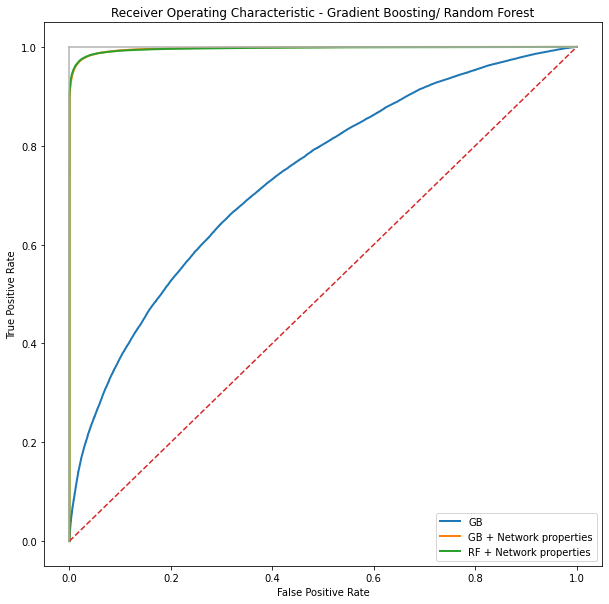

In [ ]:
y_score1 = gbc.predict_proba(X_test)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = metrics.roc_curve(y_test, y_score1)

y_score2 = rfc.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = metrics.roc_curve(y_test, y_score2)

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Gradient Boosting/ Random Forest')
plt.plot(false_positive_rate0, true_positive_rate0, lw=2)
plt.plot(false_positive_rate1, true_positive_rate1, lw=2)
plt.plot(false_positive_rate2, true_positive_rate2, lw=2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(['GB','GB + Network properties','RF + Network properties'])
plt.show()


### Example of item *suggestions*

In [ ]:
def testing(k):
  elem = df_all.iloc[k,0]
  print('Node chosen',elem)
  elem_df = id_[id_['ID']==elem].iloc[:,[1,4,5,6,7]].reset_index(drop=True)
  selected = df_all[df_all['from_ID']==elem].reset_index(drop=True)
  zin = gbc.predict(selected.filter(cols))
  #print(zin)
  index = np.where(zin==1)[0]
  best =selected.iloc[index,:].sort_values(by=['cosine_sim'],ascending=False)['to_ID'].head(10)

  sim_df = id_[id_['ID'].isin(best.values)].iloc[:,[1,4,5,6,7]].reset_index(drop=True).sort_values(by=['rank'],ascending=True)

  viewed = id_[id_['ID']==elem]['also_view'].tolist()
  viewed = id_[id_['ID'].isin(viewed[0])].iloc[:,[1,4,5,6,7]].reset_index(drop=True)

  return elem_df, sim_df, elem, viewed

In [ ]:
k = np.random.randint(0,len(df_all))
elem_df, sim_df, elem, viewed = testing(k)
display(elem_df)
print('-------------------')
print('-------------------')
print('Suggested items')
display(sim_df)
print('-------------------')
print('-------------------')
print('Also viewed items')
display(viewed)

Node chosen B00008WT60


,title,price,rank,brand,category
0,"Great Stars of Opera, Vol. 2 - Telecasts from ...",34.95,174409,Anna Moffo,"[Movies & TV, Musicals & Performing Arts, Clas..."


-------------------
-------------------
Suggested items


,title,price,rank,brand,category
5,Jussi Bjorling: He Sang With a Tear in His Voice,17.90,100644,Jussi Bjorling,"[Movies & TV, Independently Distributed, Docum..."
2,Voices of Firestone: Jussi Bjorling,19.99,137827,Puccini,"[Movies & TV, Musicals & Performing Arts, Clas..."
3,Voices of Firestone: The Great Tenors / Bjorli...,19.99,138175,Franco Corelli,"[Movies & TV, Musicals & Performing Arts, Clas..."
1,Three Legendary Tenors,19.99,145474,Enrico Caruso,"[Movies & TV, Musicals & Performing Arts, Clas..."
0,Great Stars of Opera - Telecasts from the Bell...,34.64,148946,Giuseppe Di Stefano,"[Movies & TV, Musicals & Performing Arts, Clas..."
7,The Merry Widow,14.94,21356,Rene Fleming,"[Movies & TV, Musicals & Performing Arts, Clas..."
4,The Metropolitan Opera: Centennial Gala,20.18,22350,John Alexander,"[Movies & TV, Musicals & Performing Arts, Ball..."
6,"Voice of Firestone Collection: Great Sopranos,...",29.99,64082,Rudolf Nureyev,"[Movies & TV, Musicals & Performing Arts, Ball..."


-------------------
-------------------
Also viewed items


,title,price,rank,brand,category
0,Great Stars of Opera - Telecasts from the Bell...,34.64,148946,Giuseppe Di Stefano,"[Movies & TV, Musicals & Performing Arts, Clas..."
1,Voices of Firestone: The Great Tenors / Bjorli...,19.99,138175,Franco Corelli,"[Movies & TV, Musicals & Performing Arts, Clas..."
2,"Voice of Firestone Collection: Great Sopranos,...",29.99,64082,Rudolf Nureyev,"[Movies & TV, Musicals & Performing Arts, Ball..."


In [ ]:
k = np.random.randint(0,len(df_all))
elem_df, sim_df, elem, viewed = testing(k)
display(elem_df)
print('-------------------')
print('-------------------')
print('Suggested items')
display(sim_df)
print('-------------------')
print('-------------------')
print('Also viewed items')
display(viewed)

Node chosen B00AMDA2OY


,title,price,rank,brand,category
0,Classic Westerns: 10-Movie Collection,9.99,3562,Randolph Scott,"[Movies & TV, Boxed Sets, Classics]"


-------------------
-------------------
Suggested items


,title,price,rank,brand,category
4,The Louis L'Amour Collection,13.99,1148,Various,"[Movies & TV, Boxed Sets, Comedy]"
5,Cowboys and Bandits - 50 Movie Collection: Boo...,12.94,15180,Roy Rogers,"[Movies & TV, Boxed Sets, Westerns]"
0,Western Classics: 50 Movies,19.95,17214,Roy Rogers,"[Movies & TV, Genre for Featured Categories, W..."
9,Cowboy Legends - 50 Movie MegaPack Digital,13.55,1878,John Wayne,"[Movies & TV, Genre for Featured Categories, W..."
1,Western Legends 50 Movie Pack,21.99,19531,John Wayne,"[Movies & TV, Boxed Sets, Westerns]"
8,70-Classic Western Stories,10.97,34995,Clayton Moore,"[Movies & TV, Boxed Sets, Westerns]"
2,Warner Home Video: Western Classics Collection,59.98,62218,Richard Widmark,"[Movies & TV, Studio Specials, Warner Home Vid..."
7,John Wayne - The Tribute Collection,6.99,6833,John Wayne,"[Movies & TV, Boxed Sets, Westerns]"
3,John Wayne: The Ultimate Collectio - 25 Movie ...,12.98,7039,John Wayne,"[Movies & TV, Boxed Sets, Westerns]"
6,Heroes of the Old West,6.87,88674,John Wayne,"[Movies & TV, Boxed Sets, Westerns]"


-------------------
-------------------
Also viewed items


,title,price,rank,brand,category
0,8 Movie Western Pack V.4,7.99,28920,Sam Elliott,"[Movies & TV, Genre for Featured Categories, W..."
1,Western Classics: 50 Movies,19.95,17214,Roy Rogers,"[Movies & TV, Genre for Featured Categories, W..."
2,Classic Western Round-Up - Volume 1: (The Texa...,13.94,72190,Dana Andrews,"[Movies & TV, Studio Specials, Universal Studi..."
3,Classic Western Round-Up: Volume 2,19.99,60957,Randolph Scott,"[Movies & TV, Genre for Featured Categories, R..."
4,Western Legends 50 Movie Pack,21.99,19531,John Wayne,"[Movies & TV, Boxed Sets, Westerns]"
5,"4 Film Favorites: John Wayne (Back to Bataan, ...",9.96,1436,John Wayne,"[Movies & TV, John Wayne Store, All Titles]"
6,John Wayne: The Fox Westerns Collection (The B...,14.49,4835,John Wayne,"[Movies & TV, Studio Specials, 20th Century Fo..."
7,Warner Home Video: Western Classics Collection,59.98,62218,Richard Widmark,"[Movies & TV, Studio Specials, Warner Home Vid..."
8,TCM Greatest Classic Films Collection: John Wa...,73.21,44850,John Wayne,"[Movies & TV, John Wayne Store, All Titles]"
9,John Wayne: The Ultimate Collectio - 25 Movie ...,12.98,7039,John Wayne,"[Movies & TV, Boxed Sets, Westerns]"


In [ ]:
k = np.random.randint(0,len(df_all))
elem_df, sim_df, elem, viewed = testing(k)
display(elem_df)
print('-------------------')
print('-------------------')
print('Suggested items')
display(sim_df)
print('-------------------')
print('-------------------')
print('Also viewed items')
display(viewed)

Node chosen B00FOLGVVM


,title,price,rank,brand,category
0,"WWE: TLC - Tables, Ladders &amp; Chairs 2013",9.97,85298,Various,"[Movies & TV, Genre for Featured Categories, S..."


-------------------
-------------------
Suggested items


,title,price,rank,brand,category
4,WWE: Royal Rumble 2013,14.73,101430,The Rock,"[Movies & TV, Genre for Featured Categories, S..."
3,WWE: Extreme Rules 2012,9.48,123458,John Cena,"[Movies & TV, Genre for Featured Categories, S..."
7,WWE: Extreme Rules 2014,29.99,123721,John Cena,"[Movies & TV, Genre for Featured Categories, S..."
5,WWE: Elimination Chamber 2013,25.95,132425,Various,"[Movies & TV, Genre for Featured Categories, S..."
9,WrestleMania 31 (DVD),19.37,39083,John Cena,"[Movies & TV, Boxed Sets, Sports]"
2,WWE: Wrestlemania 28 (DVD),9.94,56069,John Cena,"[Movies & TV, Boxed Sets, Sports]"
0,WWE: Money in the Bank 2011,9.95,57139,CM Punk,"[Movies & TV, Genre for Featured Categories, S..."
1,WWE: Hell in a Cell 2011,7.79,79482,John Cena,"[Movies & TV, Genre for Featured Categories, S..."
6,WWE: Payback,5.35,80106,Various,"[Movies & TV, Genre for Featured Categories, K..."
8,WWE: Royal Rumble,19.97,95219,John Cena,"[Movies & TV, Genre for Featured Categories, S..."


-------------------
-------------------
Also viewed items


,title,price,rank,brand,category
0,WWE: Judgment Day 2009,15.98,164692,Dave Bautista,"[Movies & TV, Genre for Featured Categories, A..."
1,"WWE: TLC - Tables, Ladders &amp; Chairs 2009",3.82,75743,DX,"[Movies & TV, Genre for Featured Categories, A..."
2,WWE: Hell in a Cell 2011,7.79,79482,John Cena,"[Movies & TV, Genre for Featured Categories, S..."
3,WWE: Wrestlemania 29 DVD,11.99,66142,John Cena,"[Movies & TV, Boxed Sets, Sports]"
4,WWE: Payback,5.35,80106,Various,"[Movies & TV, Genre for Featured Categories, K..."
5,WWE: Money in the Bank 2013,11.99,123139,Various,"[Movies & TV, Genre for Featured Categories, S..."
6,WWE: Extreme Rules 2014,29.99,123721,John Cena,"[Movies & TV, Genre for Featured Categories, S..."
7,WWE: Survivor Series 2015 (DVD),14.97,103878,Undertaker,"[Movies & TV, Genre for Featured Categories, S..."


In [ ]:
k = np.random.randint(0,len(df_all))
elem_df, sim_df, elem, viewed = testing(k)
display(elem_df)
print('-------------------')
print('-------------------')
print('Suggested items')
display(sim_df)
print('-------------------')
print('-------------------')
print('Also viewed items')
display(viewed)

Node chosen B00DP4AH5Q


,title,price,rank,brand,category
0,Lost &amp; Found,7.99,34674,Jim Broadbent,"[Movies & TV, Genre for Featured Categories, K..."


-------------------
-------------------
Suggested items


,title,price,rank,brand,category
5,Big Block Singsong: Vol. 1,14.99,13551,Various,"[Movies & TV, Studio Specials, Sony Pictures H..."
8,Peppa Pig: Cold Winter Day,9.96,15085,John Sparkes (voice),"[Movies & TV, Studio Specials, 20th Century Fo..."
2,Peppa Pig: My Birthday Party,9.90,2125,n/a,"[Movies & TV, Studio Specials, 20th Century Fo..."
4,Guess How Much I Love You: Hidden Treasure,9.99,29225,Stuart Allan,"[Movies & TV, Studio Specials, Sony Pictures H..."
3,Peppa Pig: The Balloon Ride,7.49,3190,Various,"[Movies & TV, Studio Specials, 20th Century Fo..."
7,Guess How Much I Love You: Hidden Treasure,8.57,57387,Stuart Allan,"[Movies & TV, Studio Specials, Sony Pictures H..."
6,Peppa Pig: Peppa's Christmas,6.97,5850,John Sparkes (voice),"[Movies & TV, Studio Specials, 20th Century Fo..."
0,Peppa Pig: Flying A Kite,12.49,82886,Peppa Pig,"[Movies & TV, Studio Specials, 20th Century Fo..."
9,Guess How Much I Love You: Autumn Journey,4.99,83794,Little Nutbrown Hare,"[Movies & TV, Genre for Featured Categories, K..."
1,Guess How Much I Love You: Friendship Adventures,6.37,87027,Stuart Allan,"[Movies & TV, Studio Specials, Sony Pictures H..."


-------------------
-------------------
Also viewed items


,title,price,rank,brand,category
0,The Gruffalo,17.94,9277,Helena Bonham Carter,"[Movies & TV, Genre for Featured Categories, K..."
1,Stellaluna,8.84,43320,Not Applicable,"[Movies & TV, Genre for Featured Categories, K..."
2,The Snowman &amp; The Snowdog,4.06,6666,The Snowman,"[Movies & TV, Genre for Featured Categories, K..."
3,Peppa Pig: My Birthday Party,9.90,2125,n/a,"[Movies & TV, Studio Specials, 20th Century Fo..."
4,Peppa Pig: Peppa's Christmas,6.97,5850,John Sparkes (voice),"[Movies & TV, Studio Specials, 20th Century Fo..."
5,Two by Two,4.99,18095,Martin Sheen (voice),"[Movies & TV, Studio Specials, Sony Pictures H..."
6,Peppa Pig: Cold Winter Day,9.96,15085,John Sparkes (voice),"[Movies & TV, Studio Specials, 20th Century Fo..."
